# **Práctica final Aprendizaje Automático:  Problema de clasificación**

### Autor: Diego Escanciano Igualador.

Este trabajo será realizado con la filosofía de "programación funcional", donde iremos importando distintas funciones creadas por nosotros para ayudarnos a completar todas las fases del trabajo. 
Empezaremos importando algunos paquetes básicos de python y de machine learning y el dataset.

In [10]:
import numpy as np # Operaciones básicas
import pandas as pd # Data science

# !pip install imblearn # Para evitar reiniciar el kernel con las funciones auxiliares

Importamos el dataset después de haber descomprimido la carpeta  .rar en una instancia local de nuestro equipo. Desafortunadamente como el dataset es muy grande no podremos subirlo a GitHub sin comprimir.

In [11]:
# Importamos los datos
df = pd.read_csv("../Data/NCDB_1999_to_2014.csv")

C:\Users\diego\AppData\Local\Temp\ipykernel_25012\347659069.py:2: DtypeWarning: Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/NCDB_1999_to_2014.csv")


# Objetivos

Nos plantearemos los siguientes objetivos que podremos extraer de este dataset:

*   ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?
*   ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

*   ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

*   Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Podría ser una información útil para las aseguradoras.
*   Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones). 

# **1. Análisis Preliminar**

In [12]:
from Analisis_preliminar_preprocesing import * # Importamos nuestro archivo Analisis_preliminar_preprocesing.py
import Analisis_preliminar_preprocesing
import importlib
importlib.reload(Analisis_preliminar_preprocesing)

<module 'Analisis_preliminar_preprocesing' from 'c:\\Users\\diego\\Documents\\Proyectos de datos\\AccidentesdeCoches\\Código\\Analisis_preliminar_preprocesing.py'>

Empezaremos echando un rápido vistazo a nuestro dataset, para observar cuántas variables tienes y que valores toman. Recordemos que los pdf adicionales que vienen en [Kaggle](https://www.kaggle.com/datasets/tbsteal/canadian-car-accidents-19942014) aportan mucha más información sobre cómo están recogidos los datos automovilísticos de accidentes y sobre qué nomenclatura emplea cada variable.

In [13]:
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860405 entries, 0 to 5860404
Data columns (total 22 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   C_YEAR  int64 
 1   C_MNTH  object
 2   C_WDAY  object
 3   C_HOUR  object
 4   C_SEV   int64 
 5   C_VEHS  object
 6   C_CONF  object
 7   C_RCFG  object
 8   C_WTHR  object
 9   C_RSUR  object
 10  C_RALN  object
 11  C_TRAF  object
 12  V_ID    object
 13  V_TYPE  object
 14  V_YEAR  object
 15  P_ID    object
 16  P_SEX   object
 17  P_AGE   object
 18  P_PSN   object
 19  P_ISEV  object
 20  P_SAFE  object
 21  P_USER  object
dtypes: int64(2), object(20)
memory usage: 983.6+ MB


Vemos la composición del dataframe, que cuenta con 22 variables y 5.860.405 registros. Vamos a cambiar el nombre de las variables para que sean más fácil de identificar, y vamos también a eliminar los registros duplicados, ya que suponen información redundante para nuestro estudio.

Además eliminaremos la variable "P_ISEV", que nos indica si en el accidente hay lesión, muerte, o ninguna de las dos porque ya que contamos con la variable "C_SEV", que ya nos indica si hay o no hay muertes en el accidente. También eliminaremos las variables "P_ID" e "V_ID" por ser variables de identificación que aportan poco interés a nuestro modelo.

In [15]:
nombres = ["año", "mes", "dia_semana", "hora", "severidad", "numero_vehiculos", "tipo_colision", "tipo_carretera", "clima",
"estado_carretera", "alineamiento_carretera", "señalizacion", "id_vehiculo", "tipo_vehiculo", "año_vehiculo", "id_pasajero", "sexo_pasajero",
"edad_pasajero", "posicion_pasajero", "severidad_pasajero", "seguridad_pasajero", "tipo_pasajero"]

nombres_eliminar = ['id_pasajero','id_vehiculo','severidad_pasajero']

df_accidentes = TratamientoDataFrame(df, nombres, nombres_eliminar)

El tamaño del dataframe era: (5860405, 22), y ahora es: (5821317, 19).


## *1.1. Elección y tratamiento de la variable objetivo*

Emplearemos como variable objetivo para este estudio la variable "severidad" que está compuesta por 1 y 2. El 1 nos indica que en el accidente han tenido lugar uno o más fallecimientos, y el 2 que no existen fallecimientos en el accidente.

Observamos mediante una tabla la proporción de la variable objetivo, binaria, en nuestro dataframe.

In [16]:
Tabla_var(df_accidentes,'severidad')

,severidad,count,porcentaje
0,2,5723822,0.983252
1,1,97495,0.016748


Se observa, como es lógico, que la mayoría de accidentes no conllevan fallecimientos. Esto supondrá más adelante la necesidad de balancear los datos para la correcta aplicación de modelos de Machine Learning.

# **2. Preprocessing**

## *2.1. Tratamiento de la variable objetivo*

Vamos a cambiar los valores por 1 y 0. De esta manera, 0 significará que hay fallecimiento en el accidente, y 1 que no lo hay.

## *2.2. Reemplazo letras por NAN* 

Siguiendo la guía de la que disponemos para nuestras variables, podemos observar que en el conjunto de datos nos encontramos con los siguientes valores en cada columna :

U, UU, UUUU: Datos desconocidos (Unknown)

N, NN, NNNN: El dato referente a esa columna no aplica al registro completo.

X,XX,XXXX: La jurisdicción no proporciona este dato.

Q,QQ,QQQQ: La elección es distinta de los valores prefijados (ver guía).

Vamos a tratar estos valores como si fuesen NAN, a excepción de la letra Q, que en lugar de transformarla en NAN, la cambiaremos por ceros, ya que las Q, como se ha explicado anteriormente, cumplen la función de 'Otro' en nuestro dataset.


## *2.3. Transformación de variables a tipo numérico*

Hemos visto previamente que todas las variables son de tipo object, a excepción de la variable "año" y la variable "severidad", que son de tipo integer.

Vamos a transformar todas las variables a tipo numérico, para después dividir nuestro dataset en dos conjuntos de train y test y así poder aplicar algoritmos de clasificación.

Vamos a convertir todas a tipo numérico, a excepción de la variable "sexo_pasajero" , que la modificaremos manualmente y la codificaremos como : Male = 1 , Female = 0.

## *2.4. Creación de la variable "edad_vehículo"*

Reemplazamos la variable "*año_vehiculo*" por "*edad_vehiculo*", asumiendo la edad del vehículo como aquella que tenía en la fecha en la que fueron recopilados los datos, creando así una variable que nos indica la antiguedad del vehículo en el momento del accidente.

**Aplicamos todo lo mencionado anteriormente empleando la función** "*Preprocesing*" **del archivo** "*Analisis_preliminar_preprocesing.py*"**.**

In [17]:
df_accidentes=Preprocesing(df_accidentes)

c:\Users\diego\Documents\Proyectos de datos\AccidentesdeCoches\Código\Analisis_preliminar_preprocesing.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.sexo_pasajero.replace({"M":1, "F":0}, inplace=True)
c:\Users\diego\Documents\Proyectos de datos\AccidentesdeCoches\Código\Analisis_preliminar_preprocesing.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beh

Así pues hemos conseguido transformar todas las variables a tipo numérico:

In [18]:
df_accidentes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5821317 entries, 0 to 5860404
Data columns (total 19 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   año                     int16  
 1   mes                     float64
 2   dia_semana              float64
 3   hora                    float64
 4   severidad               int8   
 5   numero_vehiculos        float64
 6   tipo_colision           float64
 7   tipo_carretera          float64
 8   clima                   float64
 9   estado_carretera        float64
 10  alineamiento_carretera  float64
 11  señalizacion            float64
 12  tipo_vehiculo           float64
 13  sexo_pasajero           float64
 14  edad_pasajero           float64
 15  posicion_pasajero       float64
 16  seguridad_pasajero      float64
 17  tipo_pasajero           float64
 18  edad_vehiculo           float64
dtypes: float64(17), int16(1), int8(1)
memory usage: 816.1 MB


## *2.5. Correlaciones entre las variables*

Realizaremos ahora la correlación entre las variables, con motivo de ver si existe mucha dependencia lineal entre variables. Si existieran dos variables claramente relacionadas se podría proceder de varias maneras, como eliminar una de esas variables directamente o realizar un Análisis de componentes Principales (PCA).

Emplearemos la función "*Correlacion*" del del archivo "*Analisis_preliminar_preprocesing.py*".

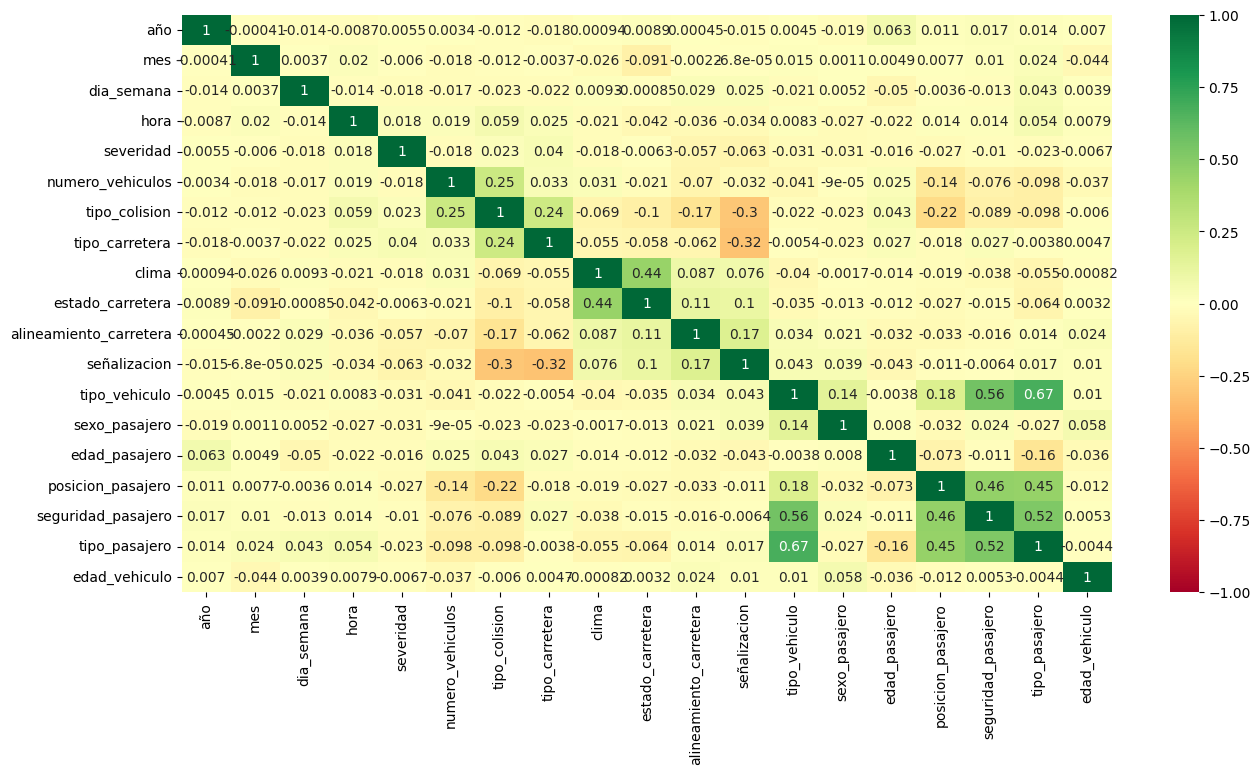

In [19]:
Correlacion(df_accidentes)

No hay una excesiva correlación entre las variables en este dataset (todas inferiores a 0.7) así pues no vemos la necesidad de eliminar o realizar un reducción de variables en ninguna variable extra por redundancias. 

# **2.6. Análisis y tratamiento de valores missing**

Realizaremos ahora el tratamiento de valores nulos del dataframe "*df_accidentes*".

**Nulos por columnas:**

In [20]:
Nulos_por(df_accidentes, 'columnas')

,Nulos por columnas,Nulos por columnas porcentaje
seguridad_pasajero,1164530,20.004580
edad_vehiculo,578643,9.940070
tipo_carretera,502936,8.639557
alineamiento_carretera,431583,7.413838
edad_pasajero,372017,6.390599
tipo_vehiculo,254498,4.371829
sexo_pasajero,230409,3.958022
señalizacion,222328,3.819204
tipo_colision,178239,3.061833
tipo_pasajero,158110,2.716052


Observamos que las variables "*seguridad_pasajero*", que contiene información relativa a "llevar puesto el cinturón", "llevar puesto el chaleco reflectante", entre otros, y "*edad_vehiculo*", son las que más valores missing presentan, la primera con un 20% de valores missing aproximadamente, seguida de un 10% para la segunda.

**Nulo por filas:**

In [21]:
Nulos_por(df_accidentes, 'filas')

,Nulos por filas,Nulos por filas porcentaje
5245711,16,0.000275
3932818,15,0.000258
5860392,15,0.000258
5562778,15,0.000258
5562769,15,0.000258
...,...,...
44,0,0.000000
45,0,0.000000
46,0,0.000000
48,0,0.000000


Veamos ahora qué cantidad exacta de observaciones tenemos en función de los registros nulos:

In [22]:
Registros_nulos(df_accidentes)

,Nulos por filas,cantidad,porcentaje
0,0,3619926,62.183970
1,1,1031652,17.721969
2,2,620842,10.664975
3,3,298220,5.122896
4,4,122878,2.110828
5,5,84045,1.443745
6,6,24317,0.417723
7,7,11746,0.201776
8,8,4867,0.083607
9,9,1743,0.029942


En consecuencia podemos eliminar sin apenas pérdida de información todos los valores donde "*nulo por filas*" sea mayor que 7, ya que apenas perderíamos un 0.14% de toda la base de datos, y además son datos de los cuales no vamos a poder extraer información.

In [23]:
df_accidentes = Eliminar_nulos_filas_n(df_accidentes,7)
Registros_nulos(df_accidentes) # Efectivamente hemos eliminado los registros con más de 7 nulos

,Nulos por filas,cantidad,porcentaje
0,0,3619926,62.266235
1,1,1031652,17.745414
2,2,620842,10.679084
3,3,298220,5.129673
4,4,122878,2.113621
5,5,84045,1.445655
6,6,24317,0.418276
7,7,11746,0.202043


Por último imputaremos el resto de valores missing por la moda (valor más frecuente) de cada atributo empleando el paquete *SimpleImputer*. Podríamos emplear métodos más sofisticados, como el "*K-NN imputer"*, pero por falta de poder computacional son inviables.

In [24]:
df_no_missing = Imputer_moda(df_accidentes)
Nulos_por(df_no_missing, 'columnas') # Efectivamente ya no tenemos nulos

,Nulos por columnas,Nulos por columnas porcentaje
año,0,0.0
mes,0,0.0
dia_semana,0,0.0
hora,0,0.0
severidad,0,0.0
numero_vehiculos,0,0.0
tipo_colision,0,0.0
tipo_carretera,0,0.0
clima,0,0.0
estado_carretera,0,0.0


Volvemos a hacer la matriz de correlaciones, pero esta vez habiéndo tratado los valores nulos.

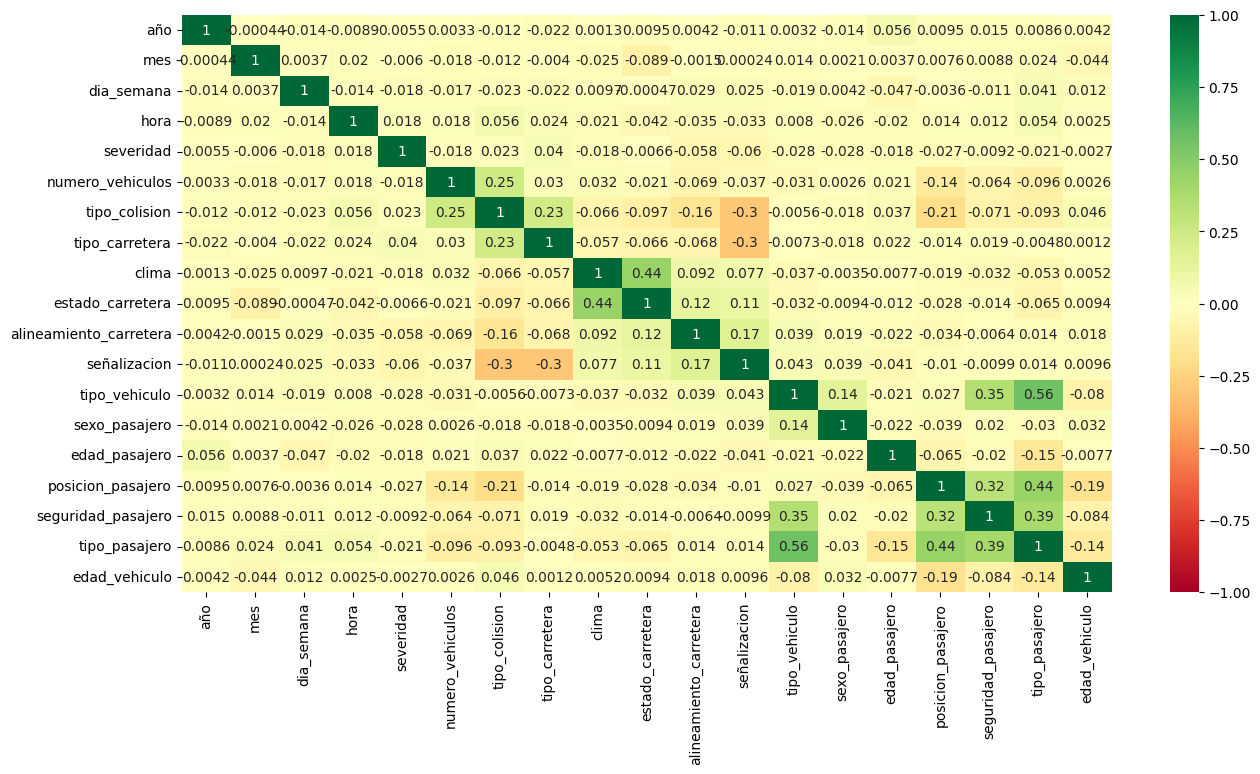

In [25]:
Correlacion(df_no_missing)

Se observa ahora una menor dependencia lineal entre todas las variables, lo que podría ser más adecuado para aplicar algunos algoritmos, pero que tiene el riesgo de perder más información sobre la variabilidad de los datos. 

# **3. Análisis exploratorio**

Vamos a realizar el análisis exploratorio sobre el dataset original, ya que con la limpieza hecha anteriormente y la imputación mediante "*Simple Imputer*" se pierde mucha información sobre la variabilidad de los datos.
Para ello, comenzaremos eliminando los valores nulos sobre el dataset original.

In [26]:
import matplotlib.pyplot as plt

In [27]:
df_expl = df_accidentes.dropna() # Quitamos valores nulos sobre el dataset original para hacer el análisis exploratorio

Importaremos nuestras funciones auxiliares que emplearemos en el análisis estadístico. Empleamos además el módulo 'importlib' que nos va a permitir actualizar nuestro archivo de python sin necesidad de actualizar el kernel.

In [28]:
from Funciones_exploratorio import * # Importamos nuestro archivo Funciones_exploratorio.py
import Funciones_exploratorio
import importlib
importlib.reload(Funciones_exploratorio)

<module 'Funciones_exploratorio' from 'c:\\Users\\diego\\Documents\\Proyectos de datos\\AccidentesdeCoches\\Código\\Funciones_exploratorio.py'>

## *3.1 Clasificación de accidentes por año*

Visualizaremos los datos de accidentes mortales y totales empleando un gráfico de lineas a lo largo de los años.

In [29]:
print(df_expl.columns)

Index(['año', 'mes', 'dia_semana', 'hora', 'severidad', 'numero_vehiculos',
       'tipo_colision', 'tipo_carretera', 'clima', 'estado_carretera',
       'alineamiento_carretera', 'señalizacion', 'tipo_vehiculo',
       'sexo_pasajero', 'edad_pasajero', 'posicion_pasajero',
       'seguridad_pasajero', 'tipo_pasajero', 'edad_vehiculo'],
      dtype='object')


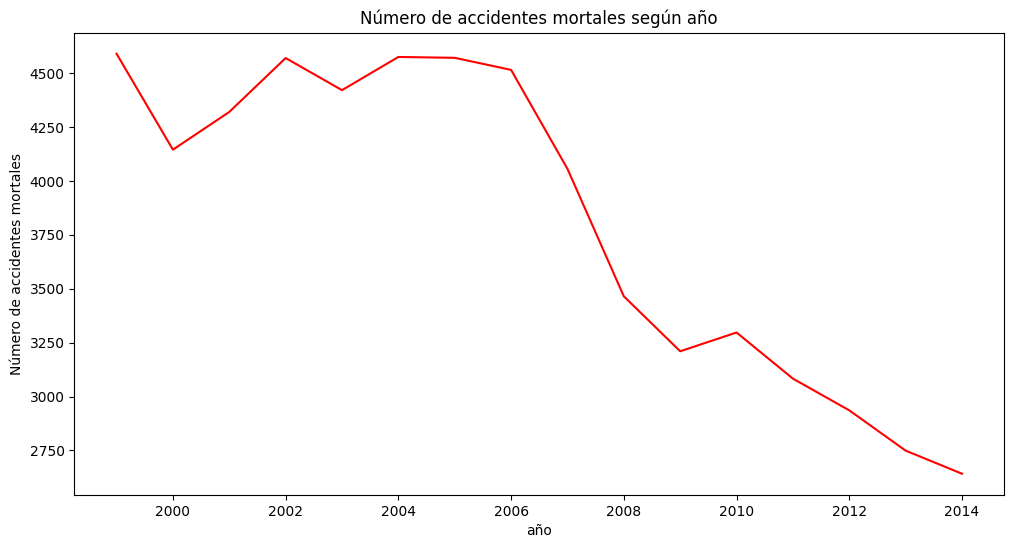

In [30]:
Lineas_accidentes_var('año',df_expl,0) # Accidentes mortales

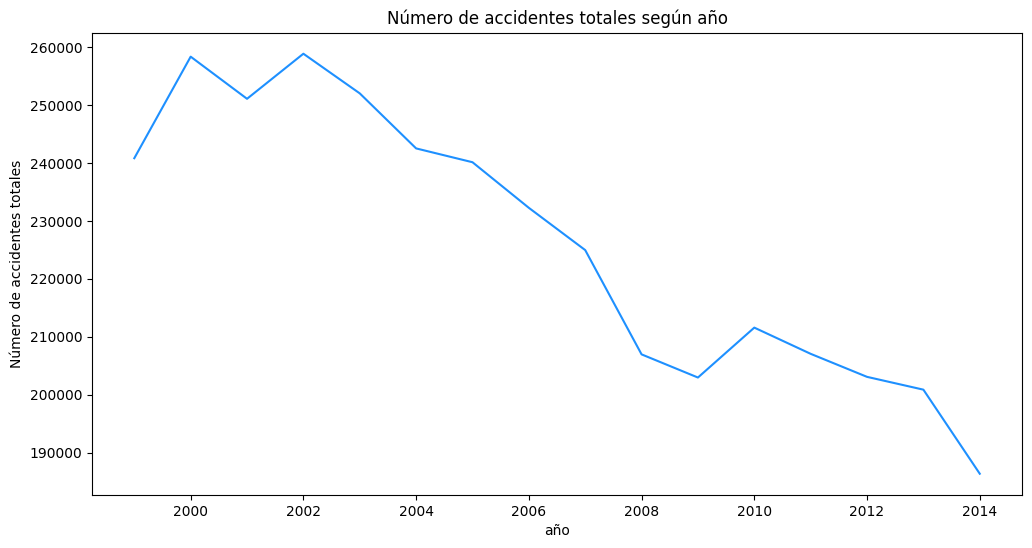

In [31]:
Lineas_accidentes_var('año',df_expl,1) # Accidentes totales

A la vista de ambas gráficas, se puede sacar una conclusión bastante clara: el número de accidentes, tanto mortales como no mortales, ha ido disminuyendo a lo largo de los años. 
Podemos observar además un hecho significativo, y es que en 15 años, los accidentes mortales se han reducido casi a la mitad, motivo quizá de que con todos los avances que se han dado durante este siglo, cada vez los vehículos son más seguros. Además, el número de accidentes no mortales también ha disminuido drásticamente.

## *3.2 Clasificación de accidentes según el tipo de vehículo*

Con esta clasificación se pretende ver qué tipos de vehículos son más propensos a tener accidentes.

In [32]:
Tabla_accidentes_var('tipo_vehiculo', df_expl,0)

,tipo_vehiculo,Num_accidentes_mortales,Porcentaje_accidentes_mortales
0,1.0,49448,80.870063
1,5.0,744,1.216780
2,6.0,2652,4.337231
3,7.0,1923,3.144983
4,8.0,2969,4.855671
5,9.0,313,0.511898
6,10.0,2,0.003271
7,11.0,777,1.270750
8,14.0,2151,3.517867
9,17.0,17,0.027803


In [33]:
Tabla_accidentes_var('tipo_vehiculo', df_expl,1)

,tipo_vehiculo,Num_accidentes_totales,Porcentaje_accidentes_totales
0,1.0,3269201,90.311266
1,5.0,44484,1.228865
2,6.0,112071,3.095947
3,7.0,46505,1.284695
4,8.0,41303,1.140990
5,9.0,10562,0.291774
6,10.0,613,0.016934
7,11.0,30015,0.829161
8,14.0,58240,1.608873
9,17.0,3038,0.083924


Con esta clasificación, se pretende mostrar la cantidad de accidentes en función del tipo de vehículo. Vemos que en el 90% de los accidentes están involucrados los vehículos de tipo 1, que se corresponde con coches de pasajeros, furgonetas de pasajeros o pick-ups.

En segundo lugar, podemos observar que el siguiente tipo de vehículo con más accidentes es el de tipo 6, que se corresponde con otros camiones y furgonetas, y estos se ven involucrados en el 3% de los accidentes. 
Los demás tipos vehículos representan cada uno, apreoximadamente, un 1% del total de accidentes y son las motocicletas, ciclomotores, las furgonetas de transporte de materiales, los camiones pesados, etc.

Vamos a visualizar en un gráfico de barras el número de accidentes en función del tipo de vehículo involucrado en este, expresado en porcentajes.

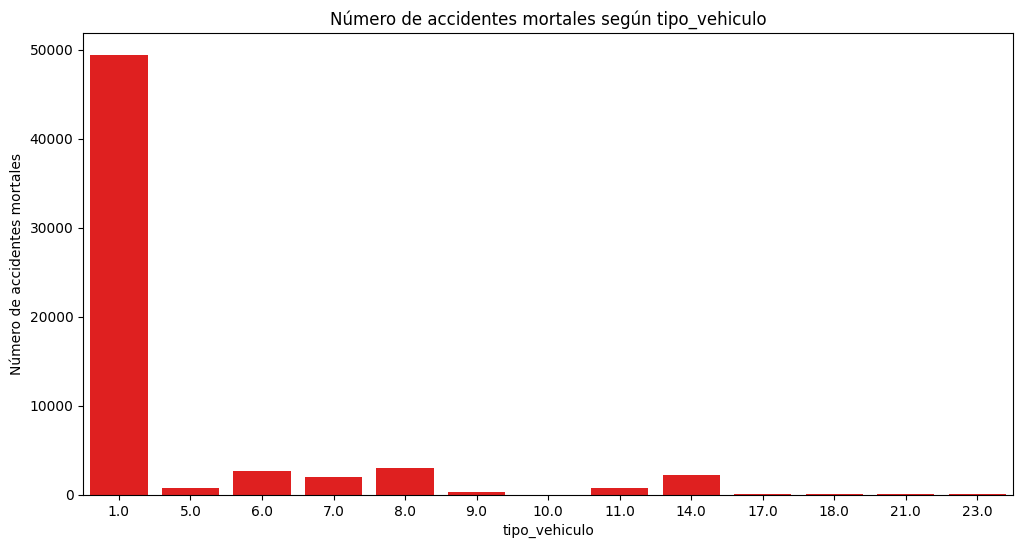

In [34]:
Barras_accidentes_var('tipo_vehiculo',df_expl,0)

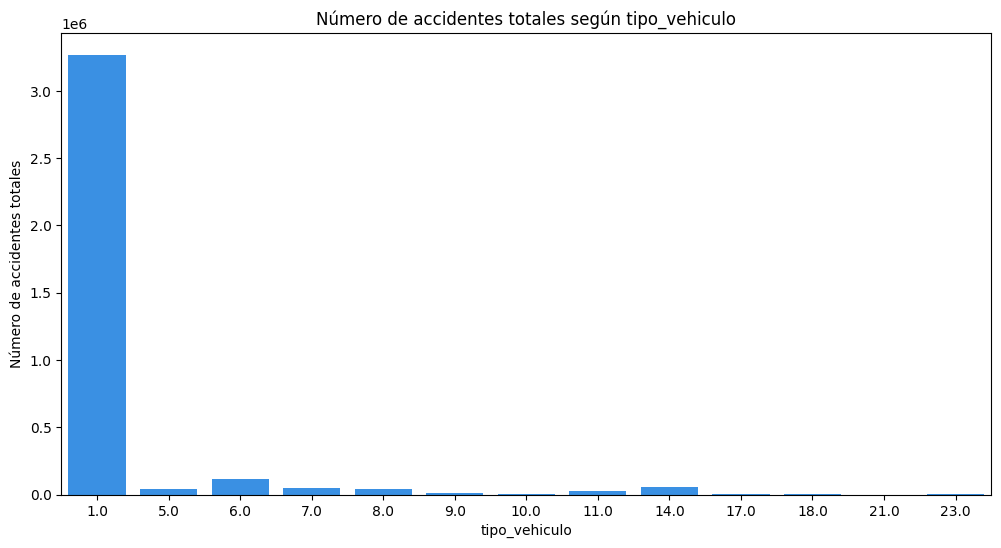

In [35]:
Barras_accidentes_var('tipo_vehiculo',df_expl,1)

## *3.3 Accidentes mortales por meses*

Vamos a visualizar gráficamente el número de accidentes mortales por mes, y se puede concluir que estos se incrementan a partir del mes de Mayo, pasando de menos de 5000 accidentes en el mes de Mayo, a más de 6000 en los meses de Julio y Agosto. Luego existe un descenso en los meses de Septiembre a Noviembre, repuntando nuevamente en Diciembre.

Esto se debe a que en los meses de verano existe más movimiento en las carreteras, al igual que en el mes de Diciembre, correspondiéndose con las vacaciones de verano y de Navidad, respectivamente. Todos estos meses superan el valor medio de accidentes mortales.

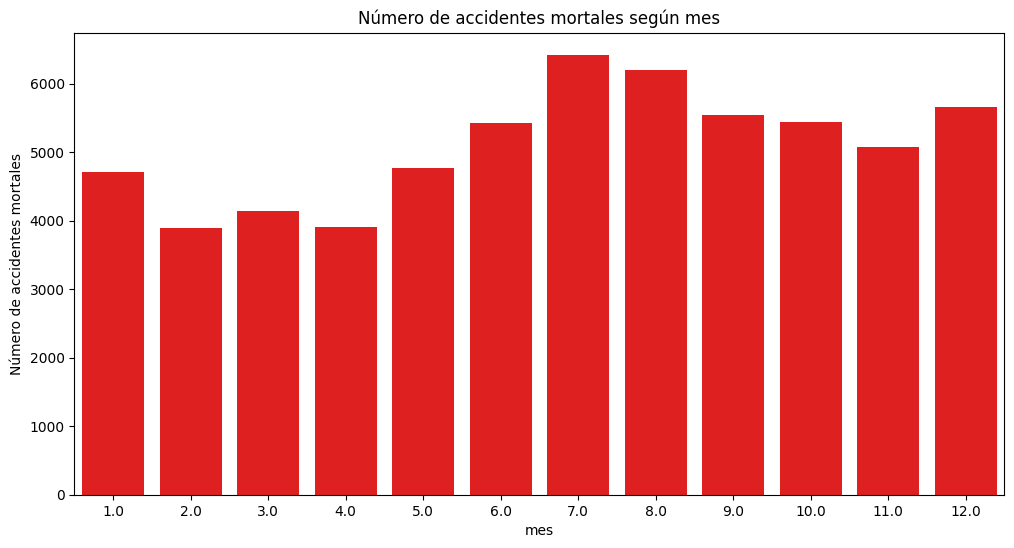

In [36]:
Barras_accidentes_var('mes', df_expl,0)

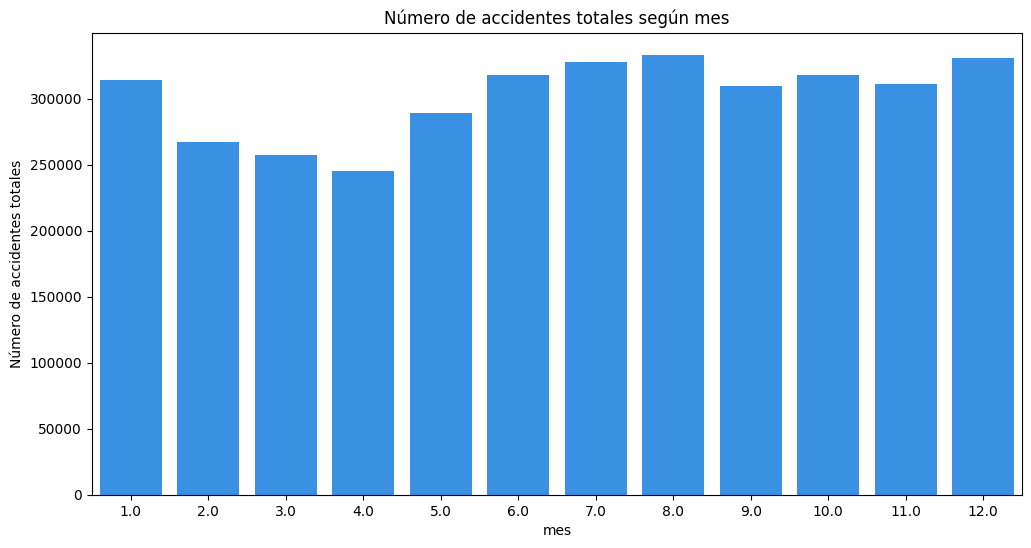

In [37]:
Barras_accidentes_var('mes', df_expl,1)

## *3.4 Accidentes por día de la semana*

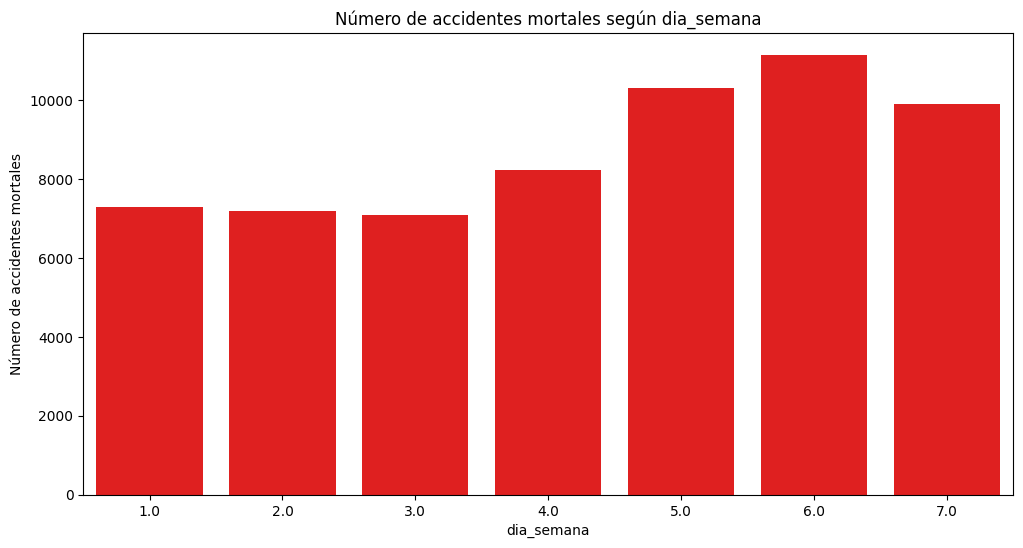

In [38]:
Barras_accidentes_var('dia_semana', df_expl,0)

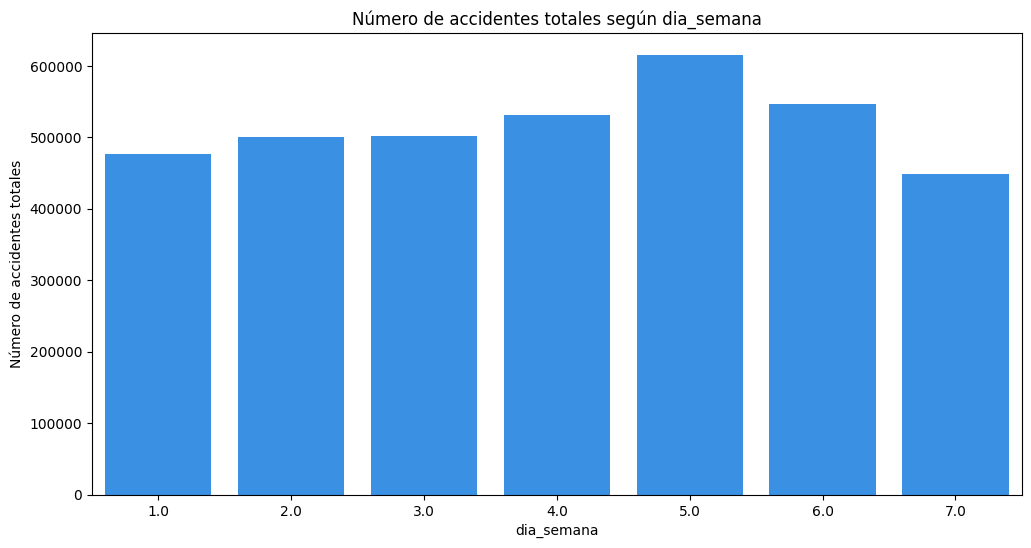

In [39]:
Barras_accidentes_var('dia_semana', df_expl,1)

En relación a los accidentes clasificados según los días de la semana, podemos ver que los días en los que más accidentes se producen son los fines de semana, en particular viernes y sábado. El motivo de de esto es que son los días en los que mayor movimiento hay en las carreteras, principalmente porque es cuando la mayoría de personas no trabajan, y vuelven a casa a pasar tiempo con la familia, los amigos, realizan planes de ocio, etc.

## *3.5 Accidentes según el clima*

Vamos a visualizar estos resultados en una gráfica y ver si se puede sacar alguna conclusión entre el número de accidentes y el clima.

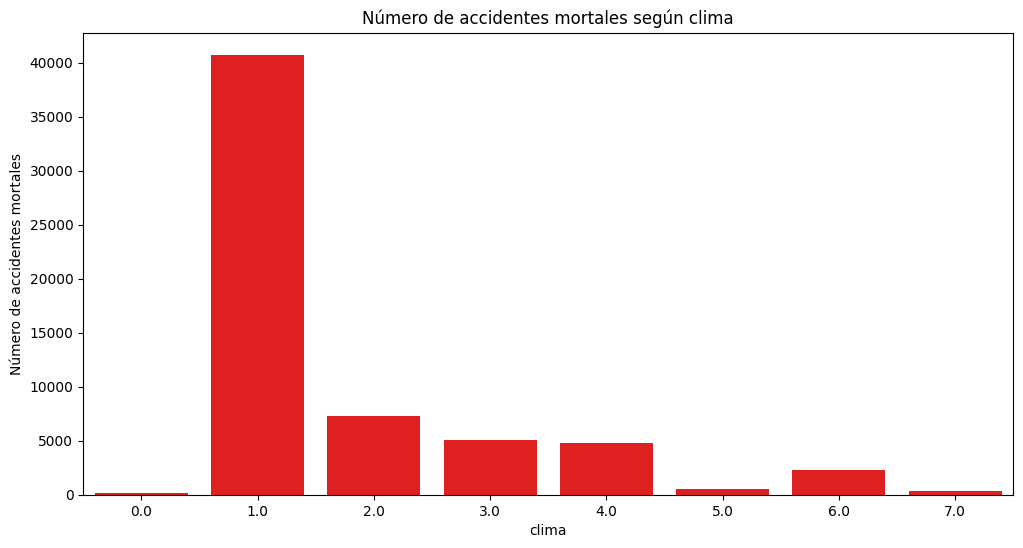

In [40]:
Barras_accidentes_var('clima', df_expl,0)

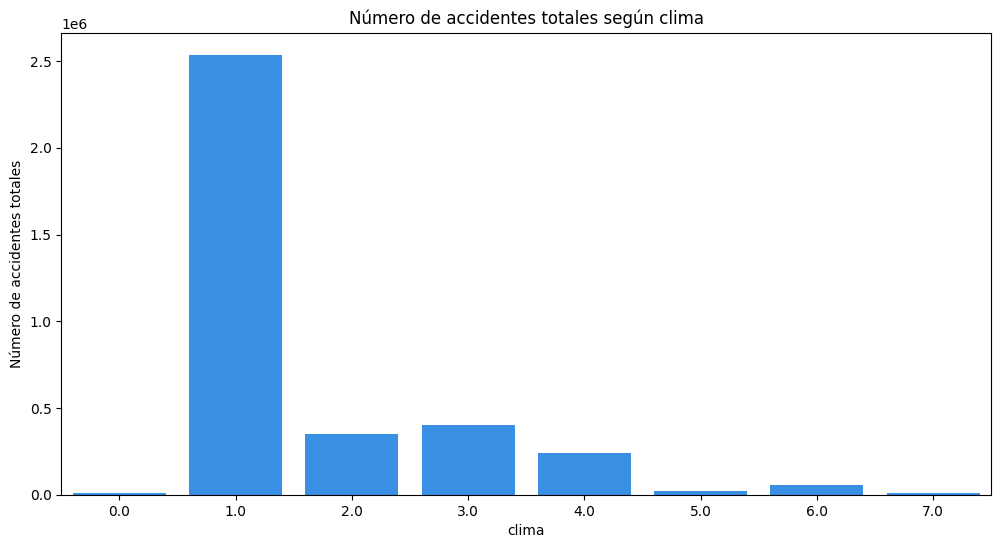

In [41]:
Barras_accidentes_var('clima', df_expl,1)

Según la codificación de nuestros valores para el clima, vemos que cuando más accidentes se producen es cuando el clima es soleado. 
Esto puede dar lugar a confusión, ya que mucha gente piensa que cuando hay fuertes lluvias, tormentas, poca visibilidad, etc. , existe un mayor riesgo de tener un accidente. Pero también es cierto que cuando el tiempo está soleado, hay más coches en la carretera (lo que implica mayor riesgo de accidentes), siendo también verdad que en los días de poca visibilidad, fuertes lluvias, etc. , la gente suele tener más prudencia y conducir con más cuidado, lo que reduce el riesgo de accidentes.

## *3.6 Accidentes según sexo*

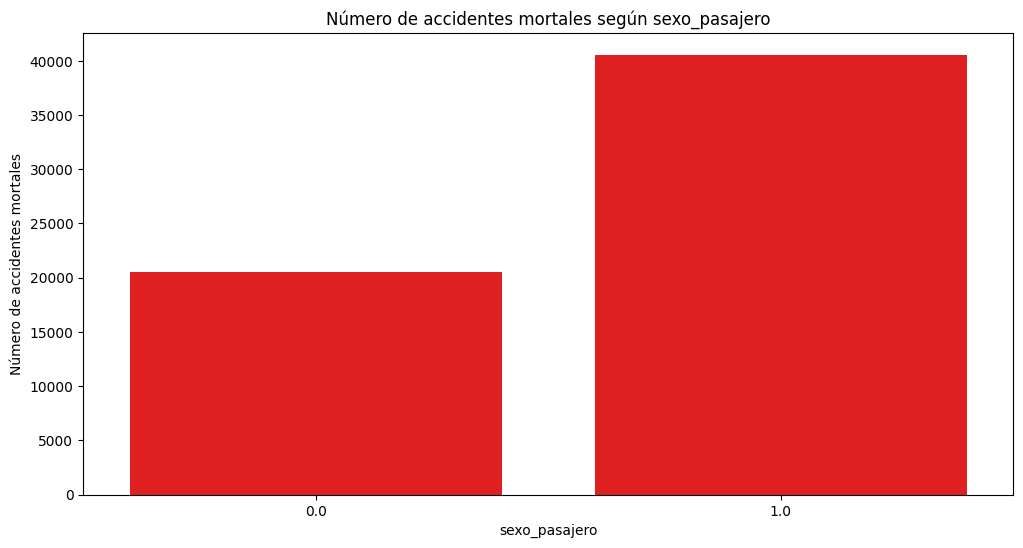

In [42]:
Barras_accidentes_var('sexo_pasajero', df_expl,0)

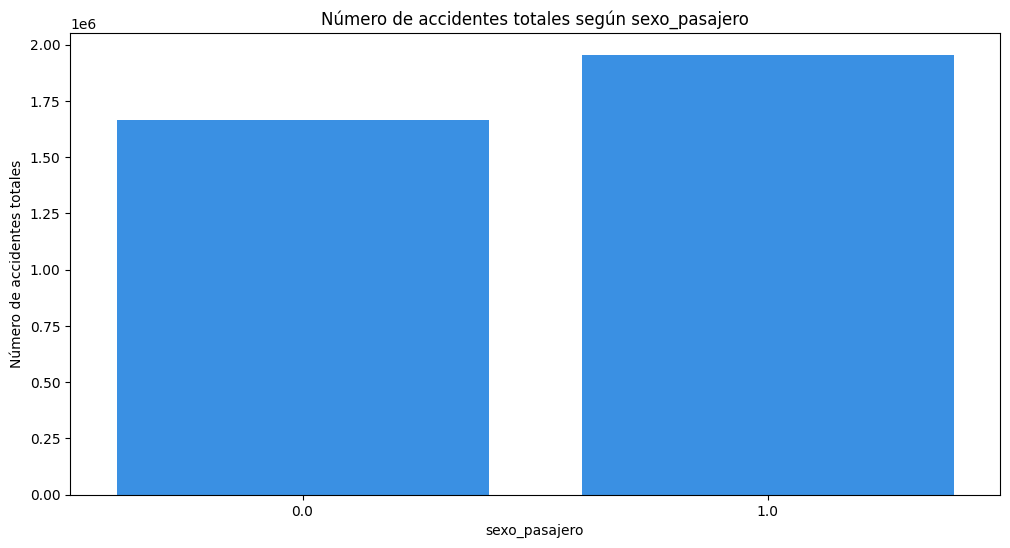

In [43]:
Barras_accidentes_var('sexo_pasajero', df_expl,1)

Atendiendo a la gráfica anterior, podemos observar que los hombres (codificados con 1) son los que más accidentes tienen, con una diferencia de casi 300.000 accidentes con respecto a las mujeres.

## *3.7 Accidentes según la edad*

Como tenemos 99 valores posibles para la edad, visualmente en un dataframe es complicado sacar conclusiones. Veremos una gráfica de barras con la distribución de accidentes según la edad de los infractores. 

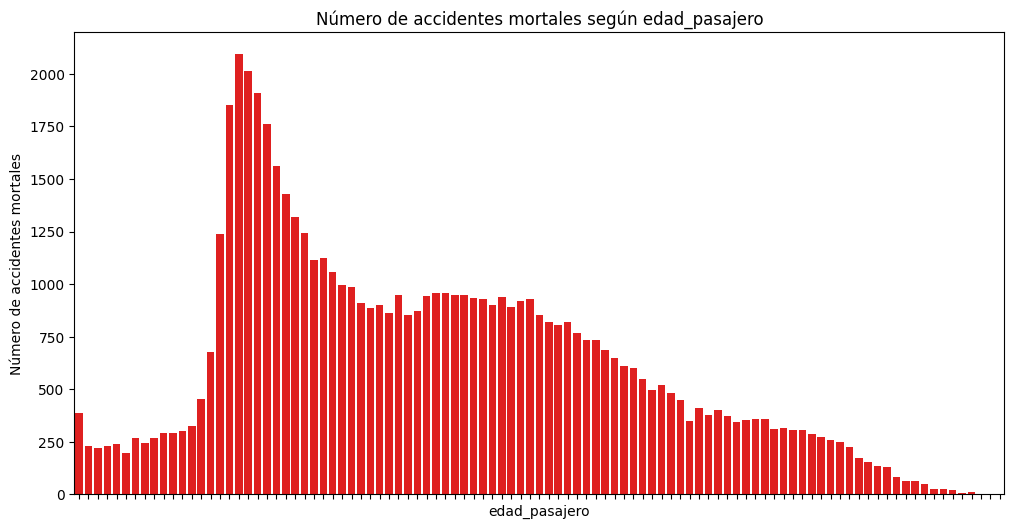

In [44]:
Barras_accidentes_var('edad_pasajero', df_expl,0)
plt.tick_params(axis='x', labelbottom=False)

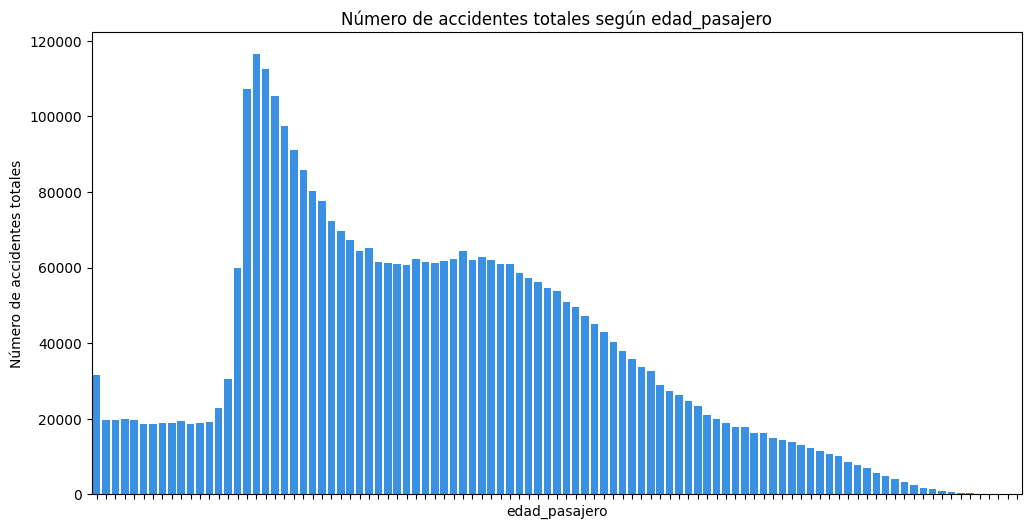

In [45]:
Barras_accidentes_var('edad_pasajero', df_expl,1)
plt.tick_params(axis='x', labelbottom=False)

Podemos observar que entre los conductores, los que más accidentes cometen se encuentran en la franja de edad entre los 17-21 años, que coincide con la edad mínima con la que se puede obtener el permiso de conducir. 
Podemos ver también que luego existe un descenso en el número de accidentes cuando la experiencia al volante es mayor, teniendo un número constante de accidentes en la franja entre los 30 - 45 años , y un número cada vez menor de los 45 años en adelante.

## *3.8 Accidentes según la hora*

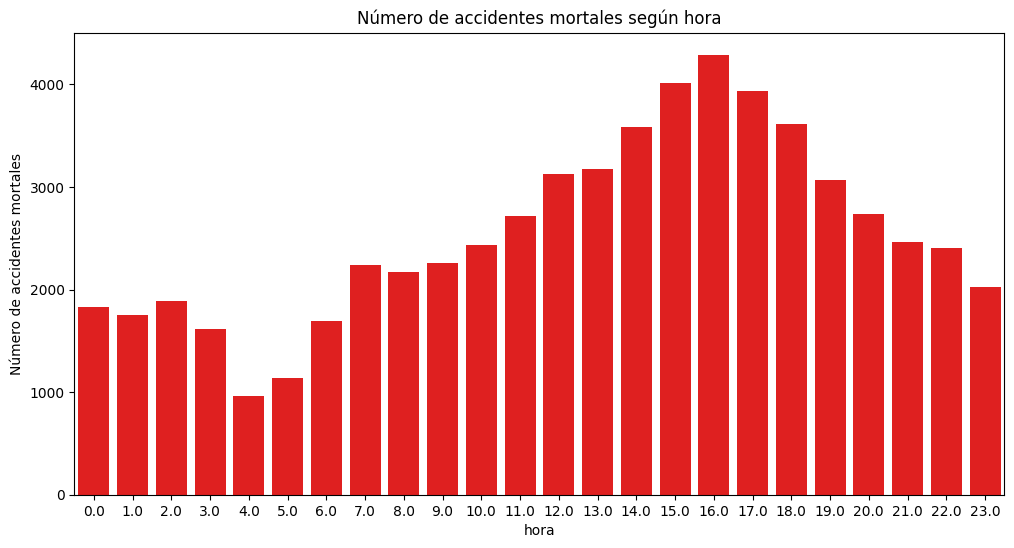

In [46]:
Barras_accidentes_var('hora', df_expl,0)

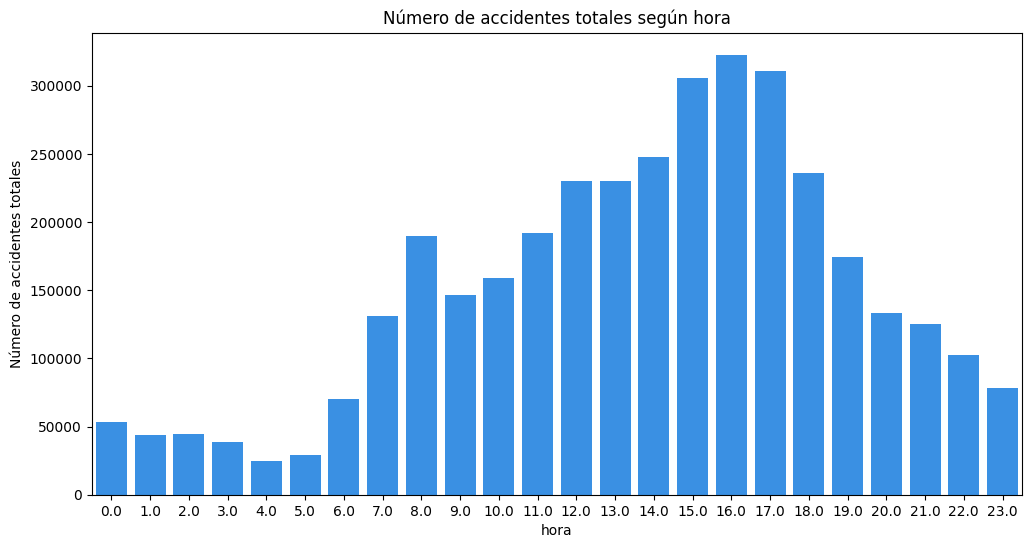

In [47]:
Barras_accidentes_var('hora', df_expl,1)

Atendiendo al gráfico anterior, podemos observar que durante las horas nocturnas (00:00 - 5:00) no se produce un gran número de accidentes. Sin embargo, existe un repunte a partir de las 6:00 en adelante, que coincide con la hora en la que mucha gente tiene que moverse para ir al trabajo, llevar los niños al colegio, etc. 
Sin duda, cuando más accidentes se producen es entre las 14 horas y las 18.00, coincidiendo con las horas en las que la mayoría de gente sale del trabajo, habiendo así muchísimo movimiento en las carreteras.

## *3.9 Número de accidentes en función de la seguridad del pasajero*

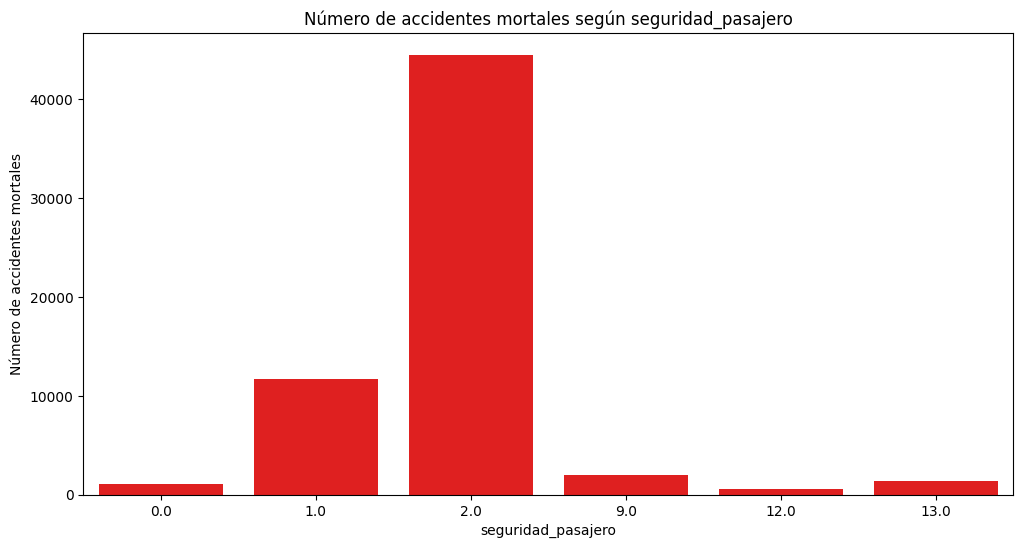

In [48]:
Barras_accidentes_var('seguridad_pasajero', df_expl,0)

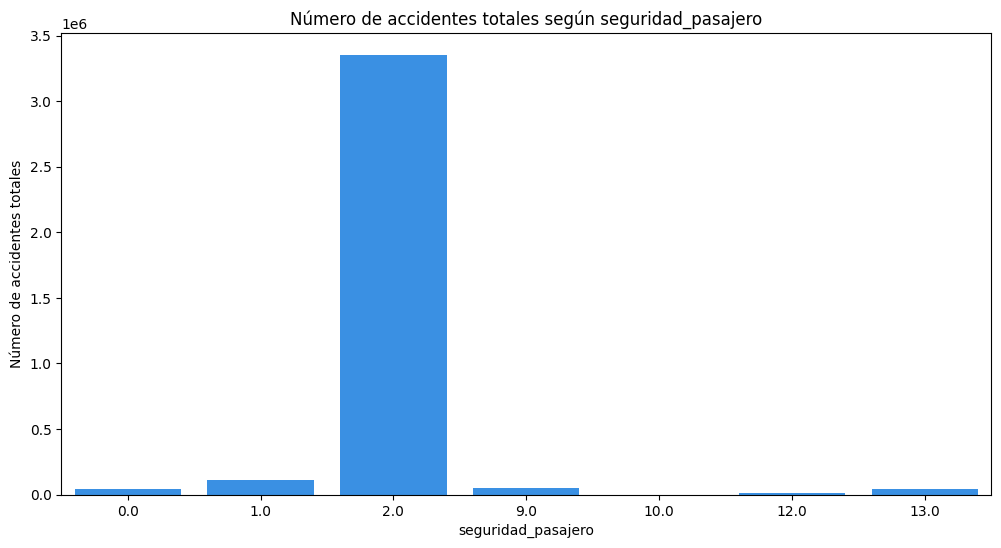

In [49]:
Barras_accidentes_var('seguridad_pasajero', df_expl,1)

En la gráfica anterior se puede observar que , con diferencia, en la mayoría de ocasiones en las que se produce un accidente, el pasajero utiliza el dispositivo de seguridad conveniente (cinturón de seguridad en el caso de los coches, etc).

Una vez vista la relación que existe entre algunas de nuestras variables dependientes y el número de accidentes cometidos, pasamos a seleccionar aquellas variables que mejor van a ajustar nuestro posterior modelo.

# *4. Selección de características*

In [53]:
from Seleccion_caracteristicas import * # Importamos nuestro archivo Funciones_exploratorio.py
import importlib
import Seleccion_caracteristicas
importlib.reload(Seleccion_caracteristicas)

<module 'Seleccion_caracteristicas' from 'c:\\Users\\diego\\Documents\\Proyectos de datos\\AccidentesdeCoches\\Código\\Seleccion_caracteristicas.py'>

## *4.1. Creación de una muestra*

Antes de dividir los datos en train y test, seleccionamos una muestra aleatoria de 100.000 valores.
Así mantenemos la estructura del dataset pero trabajamos con menos registros, lo que nos beneficia a la hora de aplicar algoritmos. 
Podemos ver que se mantiene la proporción de la variable objetivo.

In [54]:
#Tomamos la muestra habiendo tratado los missing
df_muestra=df_Muestra(df_no_missing,100000,'severidad')

   severidad  Count  Porcentaje
0        1.0  98312     0.98312
1        0.0   1688     0.01688


## *4.2 Balanceo de la muestra*

Podemos observar del apartado anterior que nuestra variable objetivo, severidad, está muy desbalanceada entre sus dos valores. Para ello empealremos las siguientes funciones y conseguir balancear los datos.

In [55]:
df_muestra_bal = Balanceo(df_muestra,'severidad')

Distribución de las estiquetas antes del 'resampling:' Counter({1.0: 98312, 0.0: 1688})
Distribución de las estiquetas después del 'resampling:' Counter({1.0: 98312, 0.0: 58987})


## *4.3 Selección de características*

Selección de características antes de balancear la muestra:

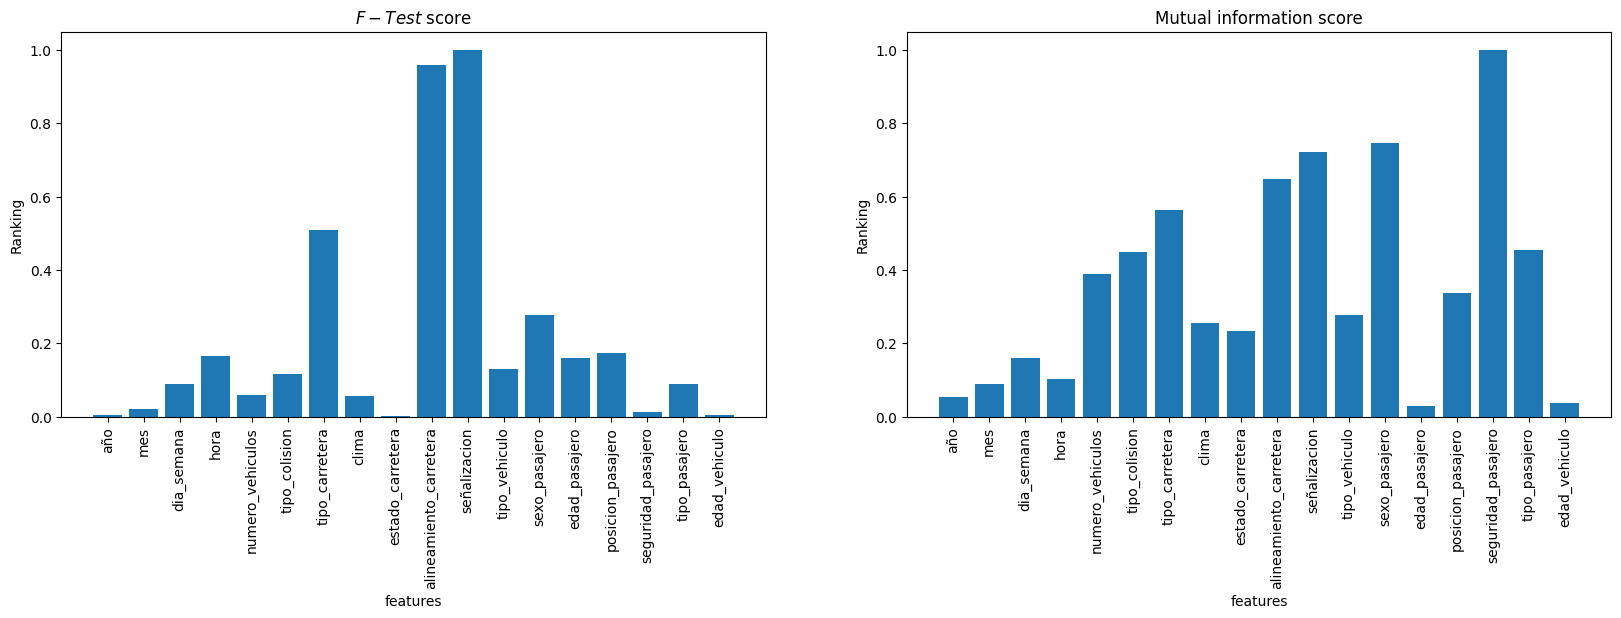

In [56]:
Seleccion_carac(df_muestra,'severidad')

Selección de características después de balancear la muestra:

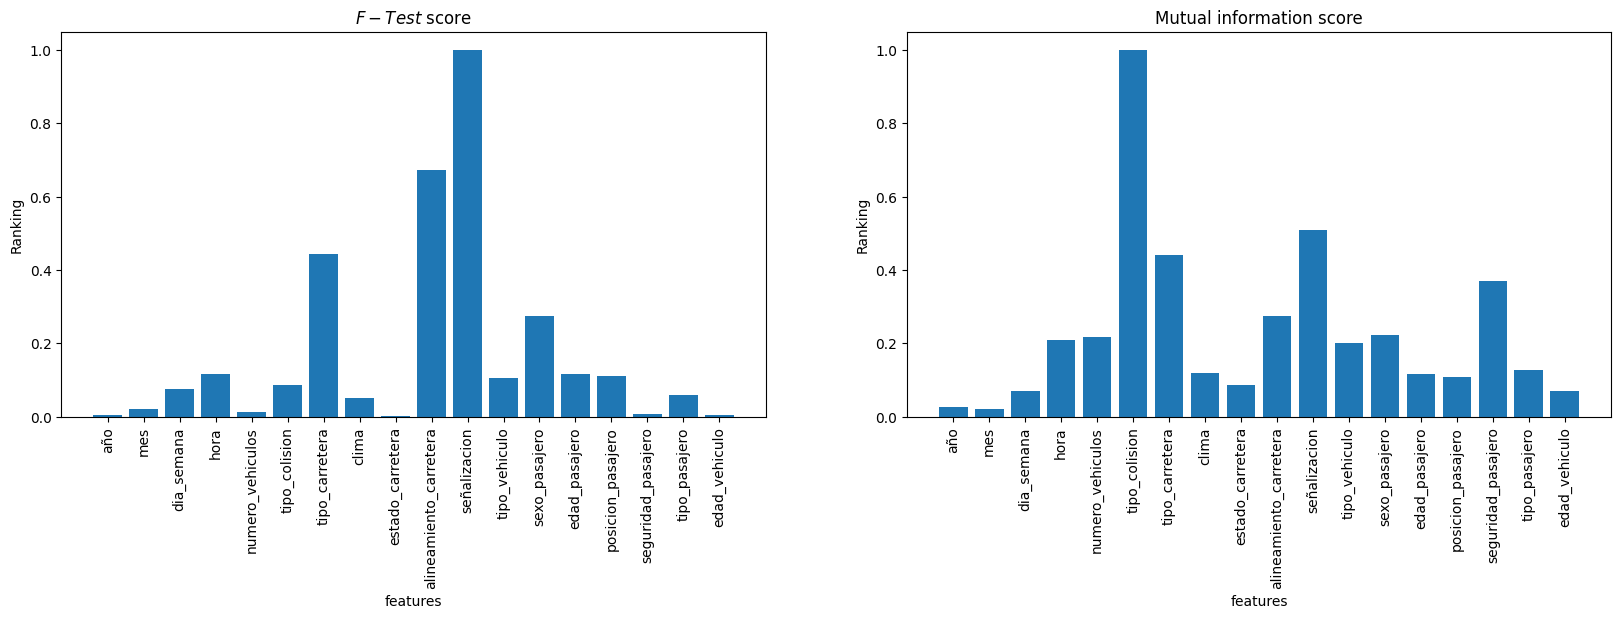

In [57]:
Seleccion_carac(df_muestra_bal,'severidad')

Así pues concluimos que los valores que más influyen (teniendo en cuenta que estamos tomando una muestra aleatoria de los valores, entonces podrían cambiar bastante los resultados en función de la muestra tomada) son:
- Señalización
- Alineamiento carretera
- Tipo Carretera
- Tipo Colisión
- Seguridad Pasajero

Notemos que factores como el clima apenas influyen en tener un accidente mortal o no.

# **5. Empleo de modelos: Clasificación de fallecimientos**

Empezamos dividiendo la muestra anterior en train y test para poder aplicar los algoritmos de clasificación.

In [59]:
from Analisis_clasificacion import * # Importamos nuestro archivo Analisis_clasificacion.py
import importlib
import Analisis_clasificacion
importlib.reload(Analisis_clasificacion)

<module 'Analisis_clasificacion' from 'c:\\Users\\diego\\Documents\\Proyectos de datos\\AccidentesdeCoches\\Código\\Analisis_clasificacion.py'>

## *División de train y test*
Dividimos la muestra en train y test. Después, dividimos cada conjunto en X e y, siendo X los conjuntos con todas las variables excepto la variable objetivo, e y la variable objetivo. Además balancearemos los datos de la variable objetivo para X_train e y_train. Esto lo hacemos dado que los accidentes sin mortalidad representan más del 95% de la muestra, lo que podría llevarnos a obtener resultados sesgados una vez apliquemos los algoritmos de clasificación. Para esto, utilizaremos la función "*Oversample*", dejando la variable objetivo más balanceada, pero manteniendo la proporción de accidentes no mortales por encima de los accidentes mortales.

In [60]:
X_train_bal, y_train_bal, X_train, y_train, X_test, y_test = train_test_div_bal(df_muestra,'severidad',0.6) # Samplig strategy = 0.6 (balanceo), consideramos 0.2 test_size.

c:\Users\diego\Documents\Proyectos de datos\AccidentesdeCoches\Código\Analisis_clasificacion.py:33: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_train_bal[column] = pd.to_numeric(X_train_bal[column], errors = 'ignore', downcast= 'integer')


## *Consideraciones previas y funciones auxiliares*

La aplicación de algoritmos que veremos a continuación se ha empleado para realizar una clasificación
tal que al recibir los datos sobre un accidente, estos algoritmos predigan si van a existir fallecidos o no.

Para ello, se han empleado los algoritmos de clasificación tales como la Regresión logística, el Árbol de decisión simple, 
el algoritmo de KNN, el clasificador XGBoost y el de Random Forest, todos ellos conocidos.

Cada algoritmo presenta su corresponidiente matriz de confusión , así como la curva ROC, ambas calculadas con las funciones 
que hemos definido anteriormente. 

Cabe comentar que en este análisis no se realizará de forma explícita la búsqueda de hiperparametros de ninguno de los modelos más abajo considerado. El principal motivo de esto es la escasa mejoría respecto a parámetros "estándar" y el elevado coste de computación asocidado a utilizar comandos como "*GridSearchCV*". Así pues los parámetros empleados se han hallado de forma experimental.

Por último crearemos la lista "*metricas_algoritmos*" en el que guardaremos todas las métricas de los algoritmos que utilizemos. El motivo de guardarlos en una lista y no en un dataframe se debe a motivos de optimización de recursos computacionales. Posteriormente convertiremos esta lista en un dataframe específico para facilitar su visualización y comparación en forma de tabla. Link del articulo en [Stackoverflow](https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-and-then-filling-it).

In [61]:
metricas_algoritmos=[]

## *5.1 Regresión logística*

La regresión logística es un método de clasificación que se utilizar para predecir el resultado de una variable categórica en función de las variables independientes o predictoras. Es útil para modelar la probabilidad de un evento ocurriendo en función de otros factores. Asigna a la variable que queremos predecir aquel valor para el que la probabilidad es mayor.

In [64]:
from Modelos_clasificación import RegresionLogistica
import Modelos_clasificación
importlib.reload(Modelos_clasificación)

<module 'Modelos_clasificación' from 'c:\\Users\\diego\\Documents\\Proyectos de datos\\AccidentesdeCoches\\Código\\Modelos_clasificación.py'>

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


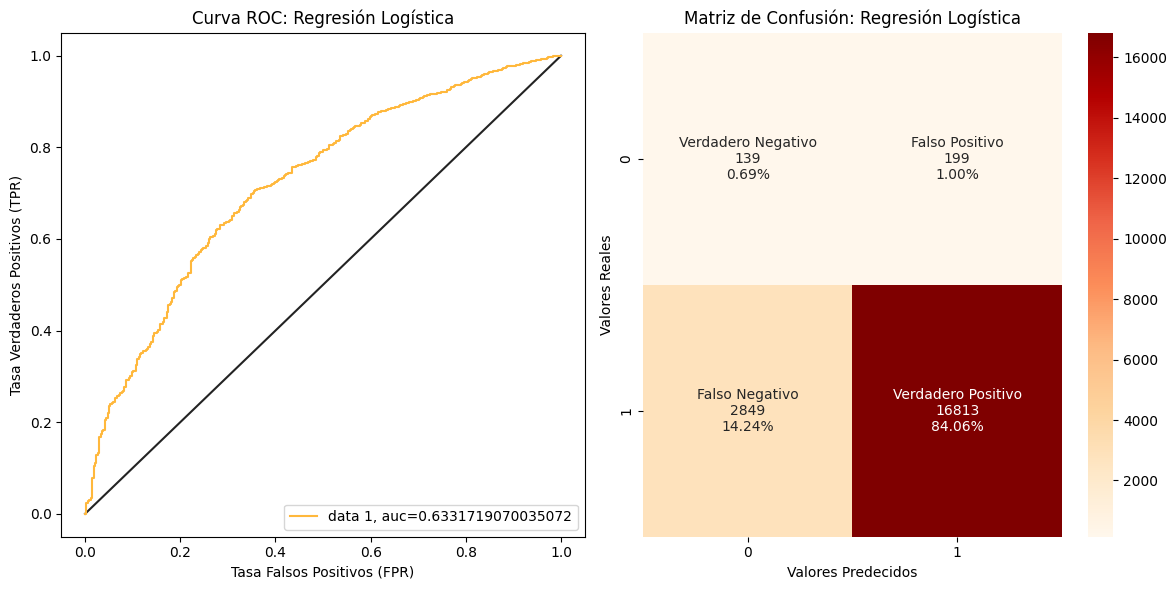

,Algorithm,Accuracy,Precision,Recall,F-Score,AUC
0,Regresión Logística (Test),0.847600,0.988302,0.855101,0.916889,0.633172
1,Regresión Logística (Train),0.848612,0.987944,0.856465,0.917519,0.623788


In [65]:
fig, metricas_algoritmos = RegresionLogistica(900, X_train_bal, y_train_bal, X_train, y_train, X_test, y_test, metricas_algoritmos)
metrica_tabla(metricas_algoritmos)

## *5.2 Árbol de decisión simple*

Un árbol de decisión es un modelo de predicción utilizado para clasificar nuestra variable objetivo en función de características relacionadas con las variables predictoras. Según el valor que tomen estas variables predictoras, el árbol pasará a un nodo u otro, llegando al nodo final, que nos da el valor de la predicción.

In [66]:
from Modelos_clasificación import ArbolDecision

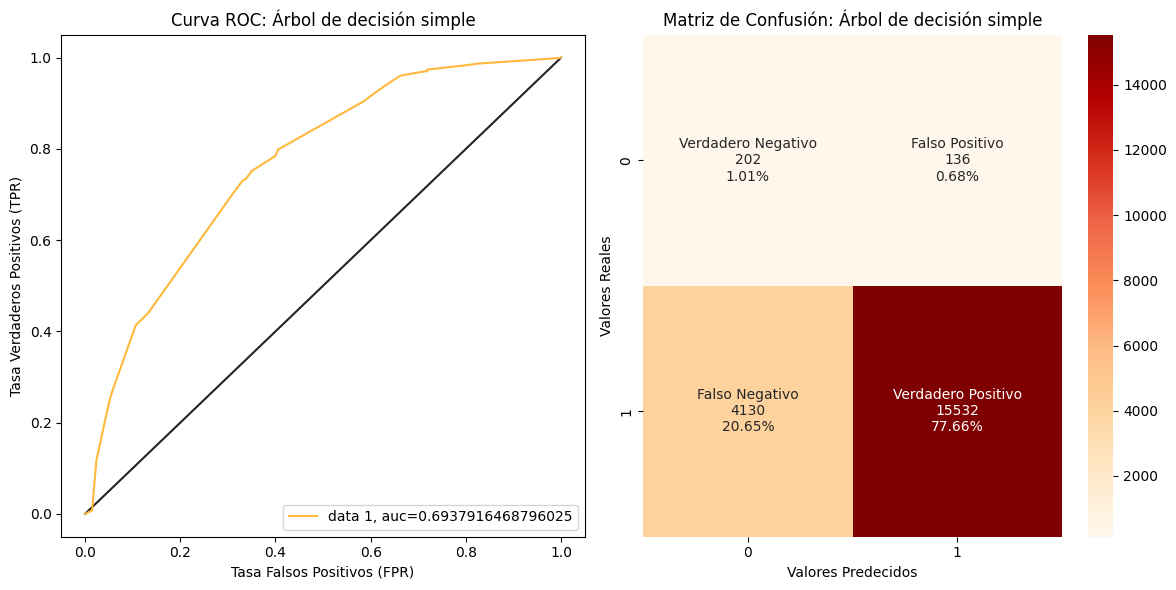

,Algorithm,Accuracy,Precision,Recall,F-Score,AUC
0,Regresión Logística (Test),0.847600,0.988302,0.855101,0.916889,0.633172
1,Regresión Logística (Train),0.848612,0.987944,0.856465,0.917519,0.623788
2,Árbol de decisión simple (Test),0.786700,0.991320,0.789950,0.879253,0.693792
3,Árbol de decisión simple (Train),0.788650,0.992015,0.791392,0.880419,0.710141


In [67]:
fig, metricas_algoritmos = ArbolDecision(5, X_train_bal, y_train_bal, X_train, y_train, X_test, y_test, metricas_algoritmos)
metrica_tabla(metricas_algoritmos)

## *5.3 Random Forest*

El random forest es un algoritmo de machine learning de uso común que combina la salida de múltiples árboles de decisión para alcanzar un solo resultado final. Es bastante útil y simple de utilizar.

In [68]:
from Modelos_clasificación import RandomForest

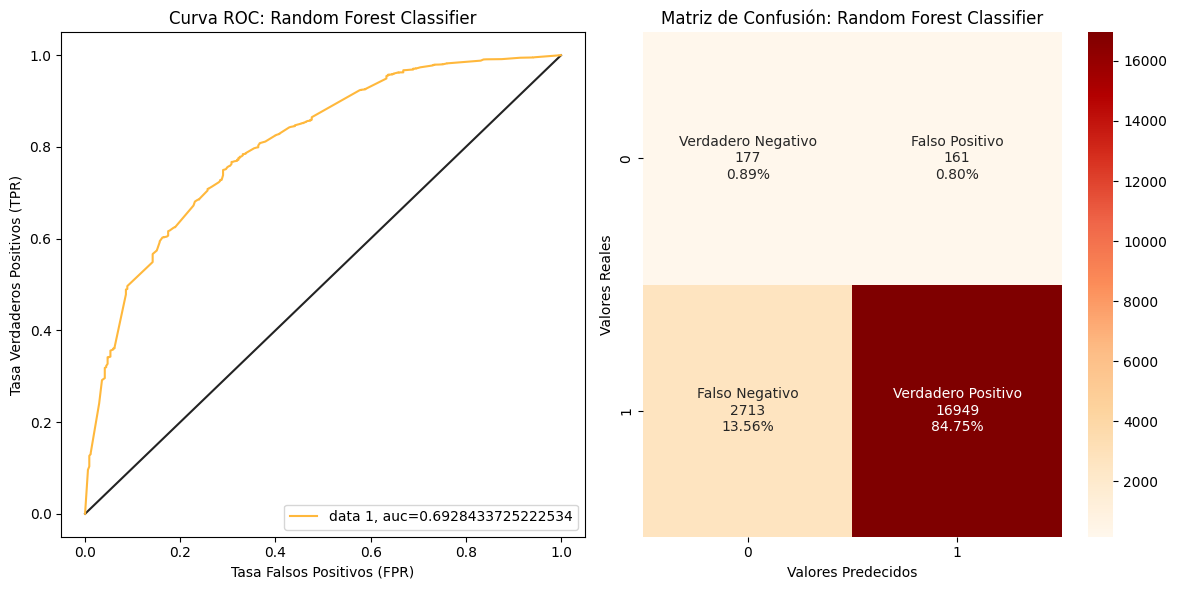

,Algorithm,Accuracy,Precision,Recall,F-Score,AUC
0,Regresión Logística (Test),0.847600,0.988302,0.855101,0.916889,0.633172
1,Regresión Logística (Train),0.848612,0.987944,0.856465,0.917519,0.623788
2,Árbol de decisión simple (Test),0.786700,0.991320,0.789950,0.879253,0.693792
3,Árbol de decisión simple (Train),0.788650,0.992015,0.791392,0.880419,0.710141
4,Random Forest Classifier (Test),0.856300,0.990590,0.862018,0.921843,0.692843
5,Random Forest Classifier (Train),0.857587,0.990676,0.863268,0.922594,0.694967


In [69]:
fig, metricas_algoritmos = RandomForest(5, X_train_bal, y_train_bal, X_train, y_train, X_test, y_test, metricas_algoritmos)
metrica_tabla(metricas_algoritmos)

## *5.4 K-NN Classifier*

El clasificador KNN o de K primeros vecinos es un algoritmo de clasificación que asigna a una nueva observación objetivo el valor de la predicción en función de sus K primeros vecinos, es decir, asigna a esta nueva observación el valor más común entre sus vecinos.

In [70]:
from Modelos_clasificación import KVecinosCercanos

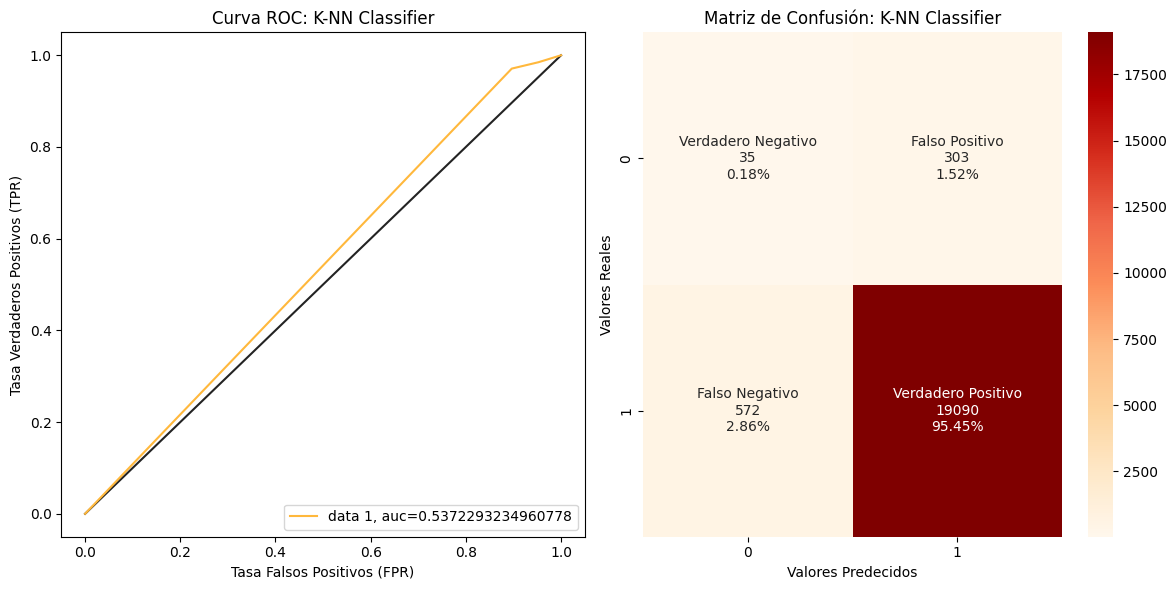

,Algorithm,Accuracy,Precision,Recall,F-Score,AUC
0,Regresión Logística (Test),0.847600,0.988302,0.855101,0.916889,0.633172
1,Regresión Logística (Train),0.848612,0.987944,0.856465,0.917519,0.623788
2,Árbol de decisión simple (Test),0.786700,0.991320,0.789950,0.879253,0.693792
3,Árbol de decisión simple (Train),0.788650,0.992015,0.791392,0.880419,0.710141
4,Random Forest Classifier (Test),0.856300,0.990590,0.862018,0.921843,0.692843
5,Random Forest Classifier (Train),0.857587,0.990676,0.863268,0.922594,0.694967
6,K-NN Classifier (Test),0.956250,0.984376,0.970908,0.977596,0.537229
7,K-NN Classifier (Train),0.985050,1.000000,0.984793,0.992338,0.992397


In [71]:
fig, metricas_algoritmos = KVecinosCercanos(2,X_train_bal, y_train_bal, X_train, y_train, X_test, y_test, metricas_algoritmos)
metrica_tabla(metricas_algoritmos)

## *5.5 XGBoost Classifier*

XGBoost es un método de aprendizaje automático supervisado para clasificación y regresión. Es la abreviatura de "extreme gradient boosting". Este método se basa en árboles de decisión y supone una mejora sobre otros métodos, como el random forest y refuerzo de gradientes. Funciona bien con datasets grandes y complejos al utilizar varios métodos de optimización.

In [72]:
from Modelos_clasificación import XGBoost

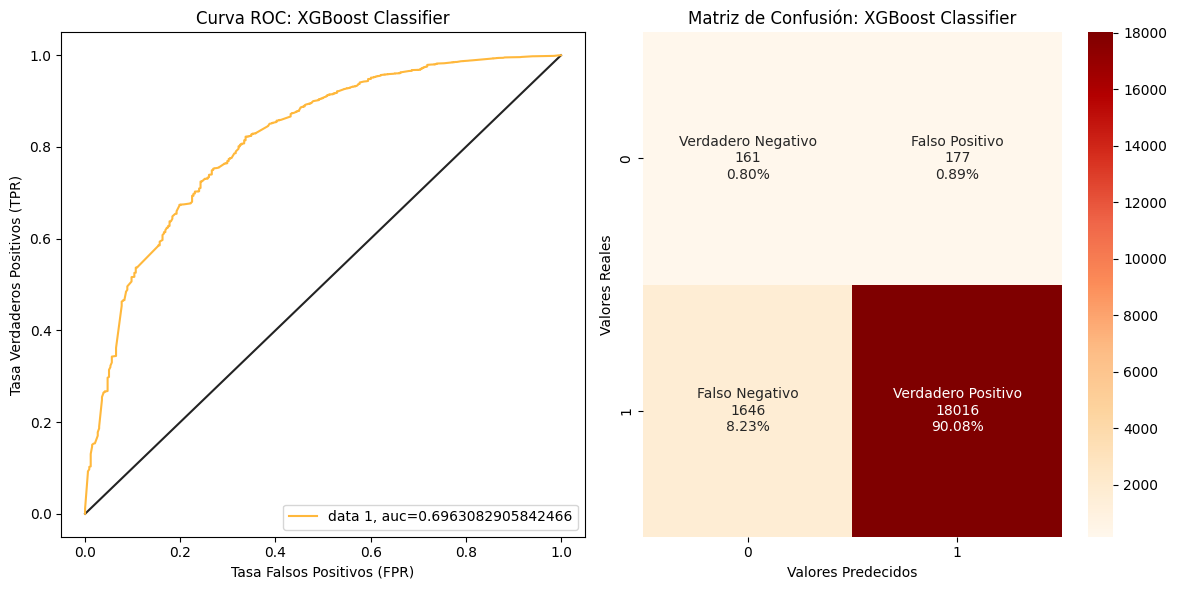

,Algorithm,Accuracy,Precision,Recall,F-Score,AUC
0,Regresión Logística (Test),0.847600,0.988302,0.855101,0.916889,0.633172
1,Regresión Logística (Train),0.848612,0.987944,0.856465,0.917519,0.623788
2,Árbol de decisión simple (Test),0.786700,0.991320,0.789950,0.879253,0.693792
3,Árbol de decisión simple (Train),0.788650,0.992015,0.791392,0.880419,0.710141
4,Random Forest Classifier (Test),0.856300,0.990590,0.862018,0.921843,0.692843
5,Random Forest Classifier (Train),0.857587,0.990676,0.863268,0.922594,0.694967
6,K-NN Classifier (Test),0.956250,0.984376,0.970908,0.977596,0.537229
7,K-NN Classifier (Train),0.985050,1.000000,0.984793,0.992338,0.992397
8,XGBoost Classifier (Test),0.908850,0.990271,0.916285,0.951843,0.696308
9,XGBoost Classifier (Train),0.912613,0.991778,0.918729,0.953857,0.737512


In [73]:
fig, metricas_algoritmos = XGBoost(5, X_train_bal, y_train_bal, X_train, y_train, X_test, y_test, metricas_algoritmos)
metrica_tabla(metricas_algoritmos)

## *Conclusiones*

Los algoritmos de **Regresión Logística** y **Árbol de decisión simple** no hacen un mal trabajo, ambos presentan un Accuracy decente, buena Precision y un Recall superior al 80%. El AUC es mejorable, especialmente en el caso de la Regresión Logística, pero presentan valores muy cercanos tanto train como test; Esto indica que los datos no están sobreajustados.

El algoritmo del **Random Forest** no presenta sobreajuste, con un recall del 93% en ambos conjuntos, superior a los demás algoritmos, y con un área debajo de la curva muy similar tanto en train como en test, del 70%.

Por su parte, los algoritmos de **K-NN** y **XGBoost no_res** presentan muy buenos resultados de Accuracy, Precision, Recall y F-Score; pero fallan de manera demasiado evidente en el AUC entre train y test; lo que indica que el modelo está demasiado sobreajustado a los datos de entrenamiento.

Por último el algoritmo de **XGBoost n=3** parámetros, si bien tiene peores métricas en Accuracy, en Recall y en F-Score; es el modelo que mejor AUC-Score presenta, con una diferencia entre sus datos de Test y Train aceptable.

Así pues los mejores modelos son el de **Random Forest** o el de **XGBoost n=3** y el peor el de **K-NN**.

## *BONUS: empleo base de datos df_eda con el método XGBoost*

Emplearemos la base de datos que hemos usado antes para el análisis exploratorio, df_exp, puesto que es toda nuestra base de datos ya tratada, df_accidentes, quitando todos los valores nulos. Así entrenamos a nuestro modelo en las mejores condiciones (mejor que si hubieramos tomado una muestra aleatoria con datos imputados).

In [74]:
#Tomamos una muestra más grande sin missing ni haber sustituido por la moda, en este caso especñifico tomamos todos los datos "buenos" (más de 3 millones)

X_train2_bal, y_train2_bal, X_train2, y_train2, X_test2, y_test2 = train_test_div_bal(df_expl,'severidad', 0.6)

metricas_algoritmos2=[]

c:\Users\diego\Documents\Proyectos de datos\AccidentesdeCoches\Código\Analisis_clasificacion.py:33: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_train_bal[column] = pd.to_numeric(X_train_bal[column], errors = 'ignore', downcast= 'integer')


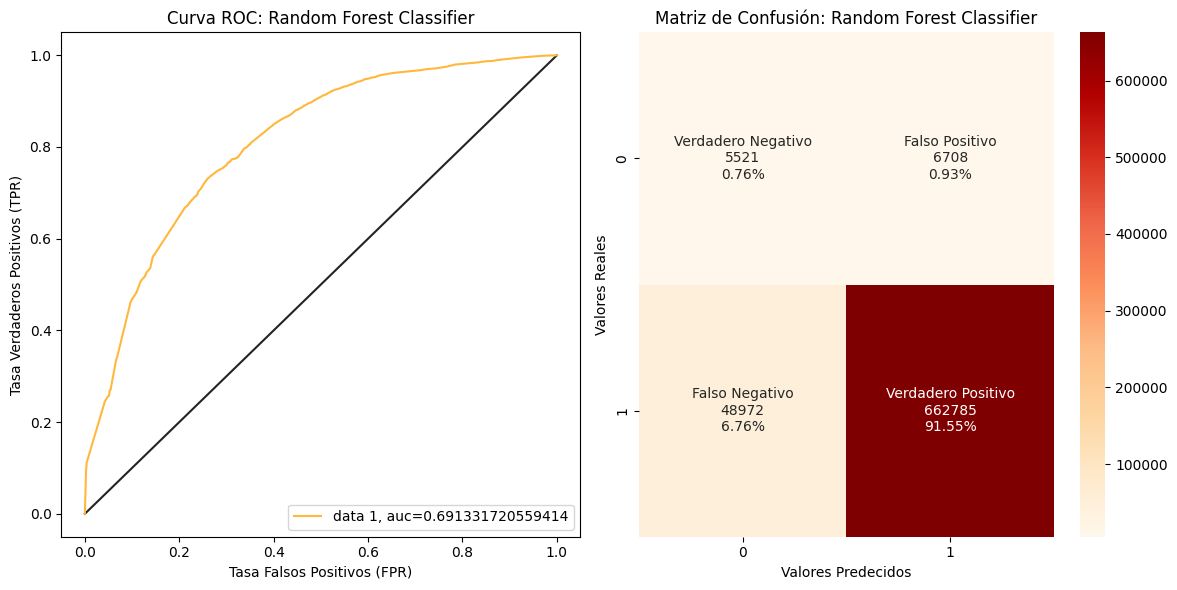

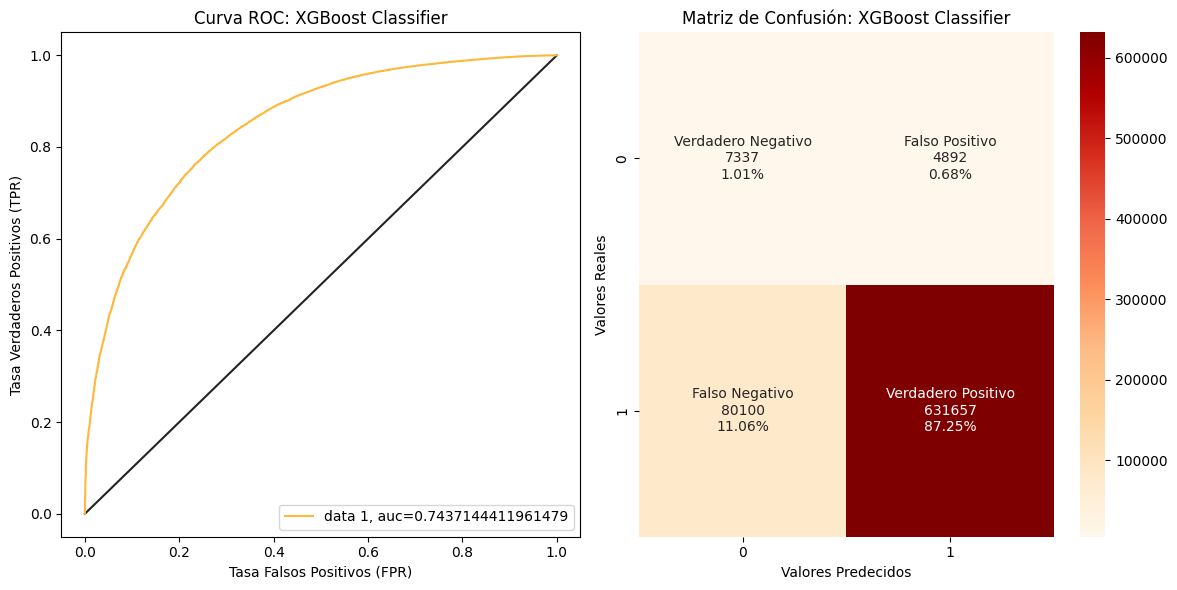

,Algorithm,Accuracy,Precision,Recall,F-Score,AUC
0,Random Forest Classifier (Test),0.923092,0.989980,0.931196,0.959689,0.691332
1,Random Forest Classifier (Train),0.923686,0.990148,0.931644,0.960006,0.696064
2,XGBoost Classifier (Test),0.882605,0.992315,0.887462,0.936964,0.743714
3,XGBoost Classifier (Train),0.883197,0.992488,0.887911,0.937291,0.748375


In [75]:
# En este caso subiremos los parámetros de ambos modelos a 15, por motivos experimentales al aumentar tanto la muestra resulta adecuado aumentar los parámetros
fig, metricas_algoritmos = RandomForest(15,  X_train2_bal, y_train2_bal, X_train2, y_train2, X_test2, y_test2, metricas_algoritmos2)
metrica_tabla(metricas_algoritmos2)
fig, metricas_algoritmos = XGBoost(15, X_train2_bal, y_train2_bal, X_train2, y_train2, X_test2, y_test2, metricas_algoritmos2)
metrica_tabla(metricas_algoritmos2)

Podemos concluir que al aumentar el tamaño de la muestra en ambos algoritmos se reduce de manera significativa el sobreajuste (mejoran los AUC-Score y con valores semejantes entre train y test).

En ambos casos han emperado las métricas de Accurancy, Recall y F-score, pero mejorado Recall y AUC. En el caso del Random Forest han empeorado muy ligeramente pero sigue teniendo un AUC considerablemente inferior que XGBoost.

Por tanto elegiremos el modelo de Random Forest, que presenta resultados sustancialmente mejores.

## **6. Empleo de modelos: Clasificación de lesiones**

Para resolver el nuevo problema y discernir si los pasajeros requerirán tratamiento médico o no tendremos que modificar la variable objetivo. Pasarempos de emplear la variable "*severity*" para emplear la variable "*passanger_severity*". Esta ultima variable informa de la severidad de la lesión del accidente de cada persona involucrada en un accidente, en una escala de ileso, lesionado y fallecido. Recordemos que nuestra variable "*severity*" nos informaba de la severidad de **un accidente**, calificandolo solamente en mortal y no mortal. El enfoque era por accidentes (donde podrían estar involucrados p automóviles y n personas) y no por personas. 

Así pues nos esperamos un análisis semejante pero con un enfoque distinto, y será vital (al igual que antes) eliminar valores duplicados porque cuando eliminamos **Valores Primarios** de una supertabla como la que es nuestro dataset "**df_accidentes**" se producirán muchas incoherencias.

In [76]:
nombres = ["año", "mes", "dia_semana", "hora", "severidad", "numero_vehiculos", "tipo_colision", "tipo_carretera", "clima",
"estado_carretera", "alineamiento_carretera", "señalizacion", "id_vehiculo", "tipo_vehiculo", "año_vehiculo", "id_pasajero", "sexo_pasajero",
"edad_pasajero", "posicion_pasajero", "severidad_pasajero", "seguridad_pasajero", "tipo_pasajero"]

nombres_eliminar2 = ['id_pasajero','id_vehiculo','severidad']

df_lesiones = TratamientoDataFrame(df, nombres, nombres_eliminar2)

El tamaño del dataframe era: (5860405, 22), y ahora es: (5824028, 19).


Aplicaremos un preprocesamiento a nuestro dataframe df_lesiones, con la variable creada anteriormente llamada "Preprocessing()" , donde pasaremos las variables a tipo int, entre otras operaciones.

In [77]:
df_lesiones=Preprocesing(df_lesiones)

c:\Users\diego\Documents\Proyectos de datos\AccidentesdeCoches\Código\Analisis_preliminar_preprocesing.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.sexo_pasajero.replace({"M":1, "F":0}, inplace=True)
c:\Users\diego\Documents\Proyectos de datos\AccidentesdeCoches\Código\Analisis_preliminar_preprocesing.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beh

Visualizamos el tipo de las variables, las dimensiones de nuestro dataset, etc.

In [78]:
df_lesiones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5824028 entries, 0 to 5860404
Data columns (total 19 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   año                     int16  
 1   mes                     float64
 2   dia_semana              float64
 3   hora                    float64
 4   numero_vehiculos        float64
 5   tipo_colision           float64
 6   tipo_carretera          float64
 7   clima                   float64
 8   estado_carretera        float64
 9   alineamiento_carretera  float64
 10  señalizacion            float64
 11  tipo_vehiculo           float64
 12  sexo_pasajero           float64
 13  edad_pasajero           float64
 14  posicion_pasajero       float64
 15  severidad_pasajero      float64
 16  seguridad_pasajero      float64
 17  tipo_pasajero           float64
 18  edad_vehiculo           float64
dtypes: float64(18), int16(1)
memory usage: 855.4 MB


En el siguiente dataframe vemos la cantidad de apariciones de la variable "severidad_pasajero" , donde vemos que 2 es el más frecuente y significa que el pasajero ha salido lesionado del accidente. En segundo lugar nos encontramos el valor 1, que hace referencia a que el pasajero ha resultado no lesionado, y en último lugar, codificado con el número 3, el pasajero ha muerto. Vemos que esta última representa tan solo el 0.7% de nuestro dataset, mientras que las otras dos representan aproximadamente un 56% y un 43%, aproximadamente.

In [79]:
Tabla_var(df_lesiones,'severidad_pasajero') # 1 no lesionado, 2 lesionado, 3 muerto [a nivel pasajero]

,severidad_pasajero,count,porcentaje
0,2.0,3065403,0.560408
1,1.0,2364227,0.432221
2,3.0,40320,0.007371


Consideraremos que dado un accidente, el pasajero necesitará tratamiento médico si la lesion ha sido grave (severidad_pasajero = 2 o severidad_pasajero = 3), es decir, si ha resultado muerto o herido y no necesitarán tratamiento médico si ha salido ileso (severidad_pasajero = 1).

Para ello, codificamos nuestra variable severidad_pasajero como 1 para aquellos pasajeros que requieran tratamiento, y 0 para aquellos pasajeros que no lo requieran. Lo visualizamos en un dataframe.

In [80]:
df_lesiones.severidad_pasajero.replace({3:2},inplace=True)
df_lesiones.severidad_pasajero.replace({2:1, 1:0},inplace=True)
Tabla_var(df_lesiones,'severidad_pasajero') # 1 no lesionado, 2 lesionado, 3 muerto [a nivel pasajero] -> 1 requiere tratamiento medico, 2 no requiere tratamiento medico

C:\Users\diego\AppData\Local\Temp\ipykernel_25012\3474464115.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_lesiones.severidad_pasajero.replace({3:2},inplace=True)
C:\Users\diego\AppData\Local\Temp\ipykernel_25012\3474464115.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

,severidad_pasajero,count,porcentaje
0,1.0,3105723,0.567779
1,0.0,2364227,0.432221


En este caso, no trataremos los datos missings, ya que hay bastantes observaciones que tienen muchos valores faltantes y a la hora de imputarlos podríamos estar obteniendo información errónea. Por tanto, decidimos eliminarlos y realizar el análisis con aquellas observaciones para las que no tenemos valores missings.

En este siguiente paso, eliminaremos en primer lugar los duplicados, por si hubiesen, y luego quitamos los valores perdidos de nuestro dataset.

In [81]:
df_lesiones=df_lesiones.drop_duplicates() # por si acaso al unificar valores de la variable objetivo hemos creado duplicados
df_lesiones_total=df_lesiones.dropna()

Con la función train_test_div_bal definida en nuestro archivo externo de funciones, creamos la división de $X_{train}$, $X_{test}$, $y_{train}$ , $y_{test}$.

In [82]:
X_train3_bal, y_train3_bal, X_train3, y_train3, X_test3, y_test3 = train_test_div_bal(df_lesiones_total,'severidad_pasajero', 'auto') # Sampling strategy auto (en realidad no hace falta balancear)

c:\Users\diego\Documents\Proyectos de datos\AccidentesdeCoches\Código\Analisis_clasificacion.py:33: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_train_bal[column] = pd.to_numeric(X_train_bal[column], errors = 'ignore', downcast= 'integer')


Aplicaremos nuestros datos a los modelos de Random Forest y de XGBoost, visualizaremos la matriz de confusión y la curva ROC de ambos.

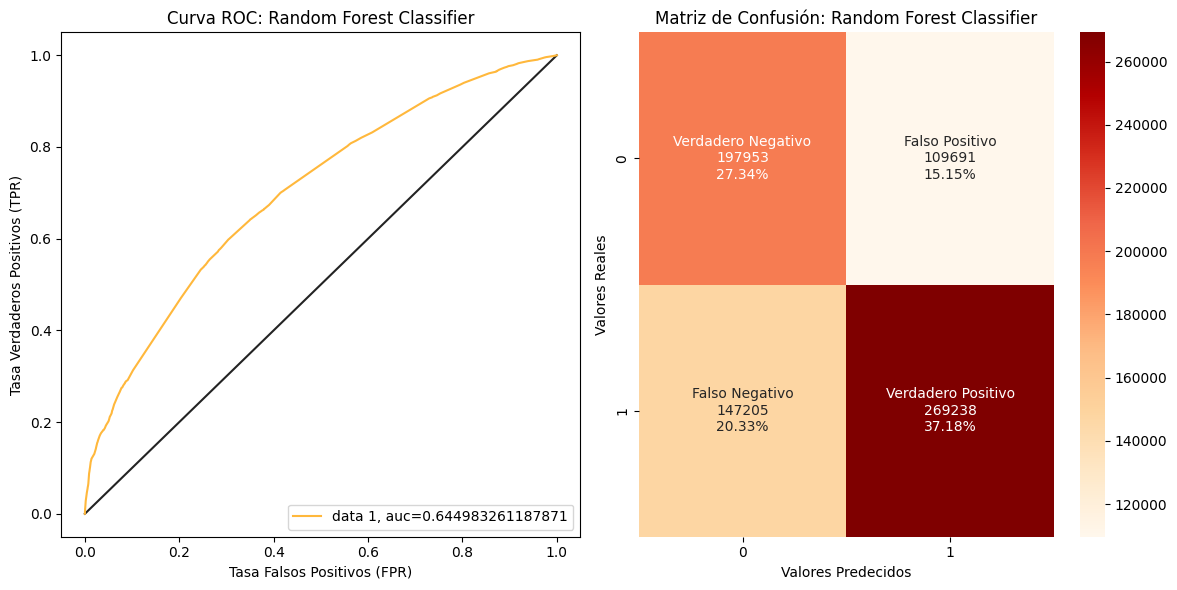

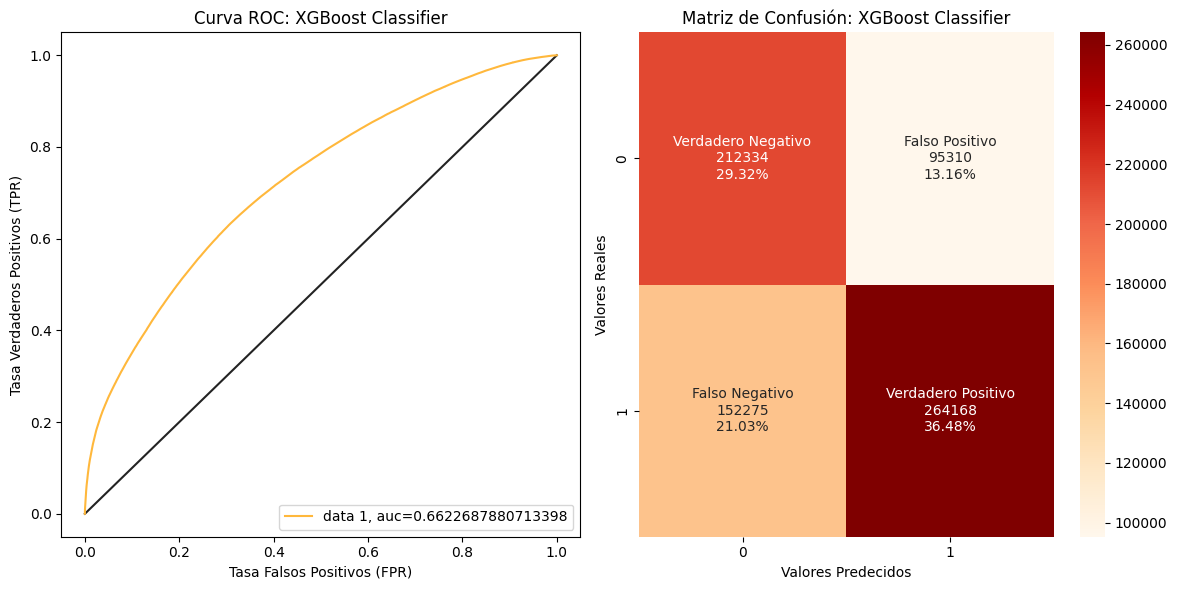

,Algorithm,Accuracy,Precision,Recall,F-Score,AUC
0,Random Forest Classifier (Test),0.645214,0.710524,0.646518,0.677012,0.644983
1,Random Forest Classifier (Train),0.644977,0.709860,0.647260,0.677116,0.644574
2,XGBoost Classifier (Test),0.658073,0.734866,0.634344,0.680915,0.662269
3,XGBoost Classifier (Train),0.657993,0.734440,0.634909,0.681057,0.662075


In [83]:
metricas_algoritmos3=[]
fig, metricas_algoritmos = RandomForest(15,  X_train3_bal, y_train3_bal, X_train3, y_train3, X_test3, y_test3, metricas_algoritmos3)
metrica_tabla(metricas_algoritmos3)
fig, metricas_algoritmos = XGBoost(15, X_train3_bal, y_train3_bal, X_train3, y_train3, X_test3, y_test3, metricas_algoritmos3)
metrica_tabla(metricas_algoritmos3)

En conclusión, se obtienen valores bastante pobres de esta predicción utilizando los modelos de Random Forest y de XGBoost. 

Se observa un accuracy del 0.65 aproximadamente para ambos algoritmos, tanto en el conjunto de train como de test. 

Además, el accuracy se encuentra alrededor del 0.64, valores que se podrían mejorar. El área bajo la curva es del 0.65 aproximadamente, por lo que concluimos que a pesar del buen tratamiento que se ha hecho de los datos, realizar una predicción de nuevas observaciones no va a ser lo suficientemente buena como nos gustaría.

Por lo que será difícil desde el punto de vista de una compañía aseguradora poder discernir si dado una nueva persona participante en un accidente esta necesitará tratamiento médico o no, obviamente consideraremos en tal caso otros factores como la llamada de auxilio a los servicios de emergencia de otras terceras personas para saber que clase de recursos emplear.